# Сборный проект —2

# Компания HR-аналитики «Работа с заботой» 

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

Поставлены две задачи:
* построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика
* построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании

# Задача №1

## Шаг. Загрузка данных

In [1]:
!pip install scikit-learn==1.4.2 -q
!pip install imblearn -q
!pip install phik -q
!pip install mlxtend -q

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import  DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from phik.report import plot_correlation_matrix

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, make_scorer


plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
try:
    train_satisfaction = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
    features_test_satisfaction = pd.read_csv('/datasets/test_features.csv', sep=',')
    target_test_satisfaction = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')
except:
    train_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', sep=',')
    features_test_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
    target_test_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', sep=',')

In [4]:
display(train_satisfaction.head())
display(features_test_satisfaction.head())
target_test_satisfaction.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [5]:
display(train_satisfaction.info())
display(features_test_satisfaction.info())
target_test_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Вывод:** Загрузил данные, имеем 3 таблицы с данными.Первая с тренировочными включая целевой признак,вторая с тестовыми признаками и третья таблица с целевым признаком тестовой выборки.Наблюдаю пропуски в данных, которые буду обрабатывать в пайплане.

## Шаг. Предобработка данных

In [6]:
display(train_satisfaction.duplicated().sum())
display(features_test_satisfaction.duplicated().sum())
target_test_satisfaction.duplicated().sum()

0

0

0

Дубликатов нет

In [7]:
for column in train_satisfaction.columns:
    unique_count = train_satisfaction[column].nunique()
    unique_values = train_satisfaction[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 4000 unique values:
[155278 653870 184592 ... 533318 706868 338347]
Столбец 'dept' имеет 5 unique values:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Столбец 'level' имеет 3 unique values:
['junior' 'middle' 'sinior' nan]
Столбец 'workload' имеет 3 unique values:
['medium' 'high' 'low']
Столбец 'employment_years' имеет 10 unique values:
[ 2  1  4  7  9  6  3 10  8  5]
Столбец 'last_year_promo' имеет 2 unique values:
['no' 'yes']
Столбец 'last_year_violations' имеет 2 unique values:
['no' 'yes']
Столбец 'supervisor_evaluation' имеет 5 unique values:
[1 5 2 3 4]
Столбец 'salary' имеет 68 unique values:
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 9

In [8]:
train_satisfaction['level'] = train_satisfaction['level'].str.replace('sinior', 'senior')

Пропуски в столбцах *level* и *dept*, 'sinior' заменил на 'senior'

In [9]:
for column in features_test_satisfaction.columns:
    unique_count = features_test_satisfaction[column].nunique()
    unique_values = features_test_satisfaction[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 2000 unique values:
[485046 686555 467458 ... 305653 160233 771859]
Столбец 'dept' имеет 6 unique values:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец 'level' имеет 3 unique values:
['junior' 'middle' 'sinior' nan]
Столбец 'workload' имеет 4 unique values:
['medium' 'low' 'high' ' ']
Столбец 'employment_years' имеет 10 unique values:
[ 2  1  5  6  3  9  7  4  8 10]
Столбец 'last_year_promo' имеет 2 unique values:
['no' 'yes']
Столбец 'last_year_violations' имеет 2 unique values:
['no' 'yes']
Столбец 'supervisor_evaluation' имеет 5 unique values:
[5 4 3 1 2]
Столбец 'salary' имеет 66 unique values:
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600

In [10]:
features_test_satisfaction['dept'] = features_test_satisfaction['dept'].replace(' ', np.nan)
features_test_satisfaction['workload'] = features_test_satisfaction['workload'].replace(' ', np.nan)
features_test_satisfaction['level'] = features_test_satisfaction['level'].str.replace('sinior', 'senior')

Пропуски в столбцах *level*, *workload* и *dept*, пустые значения заменил на nan, 'sinior' заменил на 'senior'

In [11]:
for column in target_test_satisfaction.columns:
    unique_count = target_test_satisfaction[column].nunique()
    unique_values = target_test_satisfaction[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 2000 unique values:
[130604 825977 418490 ... 857722 303402 648995]
Столбец 'job_satisfaction_rate' имеет 98 unique values:
[0.74 0.75 0.6  0.72 0.08 0.76 0.64 0.38 0.14 0.59 0.91 0.78 0.7  0.79
 0.34 0.81 0.23 0.4  0.58 0.77 0.68 0.24 0.42 0.69 0.47 0.35 0.71 0.83
 0.61 0.65 0.37 0.45 0.63 0.82 0.16 0.89 0.28 0.32 0.88 0.36 0.33 0.31
 0.27 0.73 0.53 0.26 0.57 0.2  1.   0.56 0.67 0.19 0.52 0.43 0.12 0.11
 0.21 0.13 0.49 0.22 0.86 0.46 0.41 0.48 0.29 0.87 0.66 0.8  0.55 0.5
 0.51 0.62 0.85 0.84 0.15 0.39 0.25 0.9  0.07 0.1  0.92 0.3  0.44 0.18
 0.93 0.54 0.96 0.09 0.99 0.17 0.95 0.06 0.94 0.03 0.98 0.97 0.04 0.05]


## Шаг. Исследовательский анализ данных

In [12]:
train_satisfaction.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,4000.0,NaN,NaN,NaN,544957.621,257883.104622,100954.0,322836.75,534082.5,771446.0,999521.0
dept,3994,5,sales,1512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,3996,3,junior,1894,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,4000,3,medium,2066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,4000.0,NaN,NaN,NaN,3.7185,2.542513,1.0,2.0,3.0,6.0,10.0
last_year_promo,4000,2,no,3880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,4000,2,no,3441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,4000.0,NaN,NaN,NaN,3.4765,1.008812,1.0,3.0,4.0,4.0,5.0
salary,4000.0,NaN,NaN,NaN,33926.7,14900.703838,12000.0,22800.0,30000.0,43200.0,98400.0
job_satisfaction_rate,4000.0,NaN,NaN,NaN,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


Вывел основные статистические характеристики данных столбца *train_satisfaction*

In [13]:
display(train_satisfaction[train_satisfaction.dept.isnull()])
train_satisfaction[train_satisfaction.level.isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Посмотрел на строки с пропусками, в столбце с *неизвестным* отделом сотрудника все занимают позицию *junior*, в столбце с *уровень занимаемой должности* все работают в отделе *продаж*

In [14]:
def function_unique(df, col):
    plt.figure()
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение по {col}', fontsize=18)
    plot.set_xlabel('Количество сотрудников', fontsize=16)

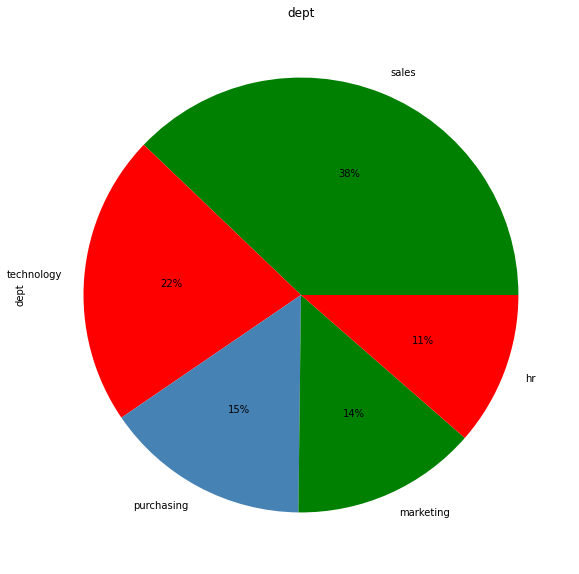

In [15]:
train_satisfaction['dept'].value_counts().plot(title='dept',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

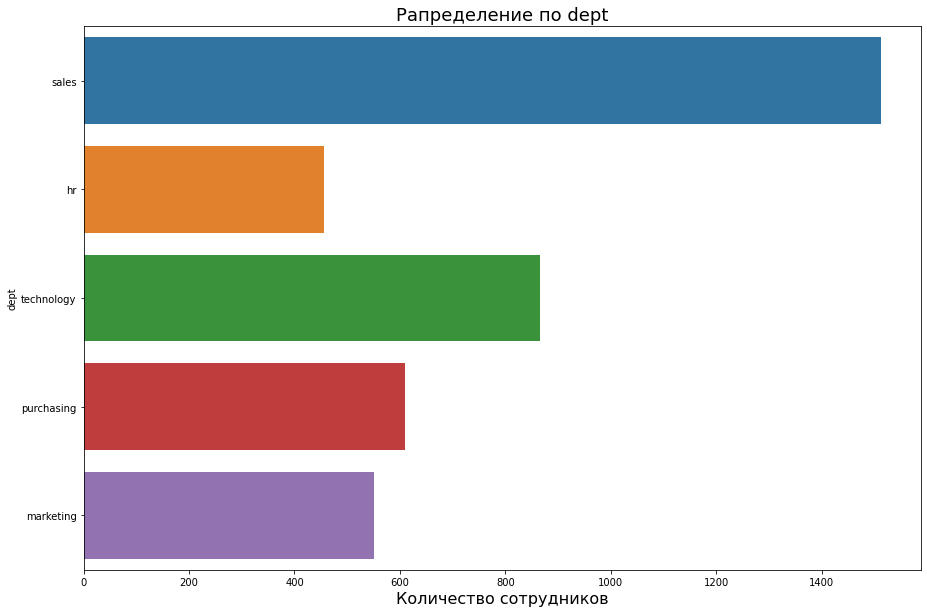

In [16]:
function_unique(train_satisfaction, 'dept')

Больше всего сотрудников в отделе *продаж*,далее отдел *технологий*, отдел *закупок*, отдел *маркетинга* и отдел *управления*

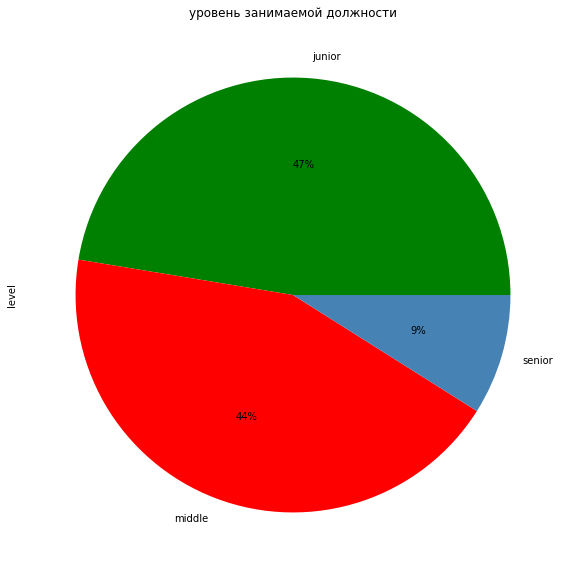

In [17]:
train_satisfaction['level'].value_counts().plot(title='уровень занимаемой должности',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

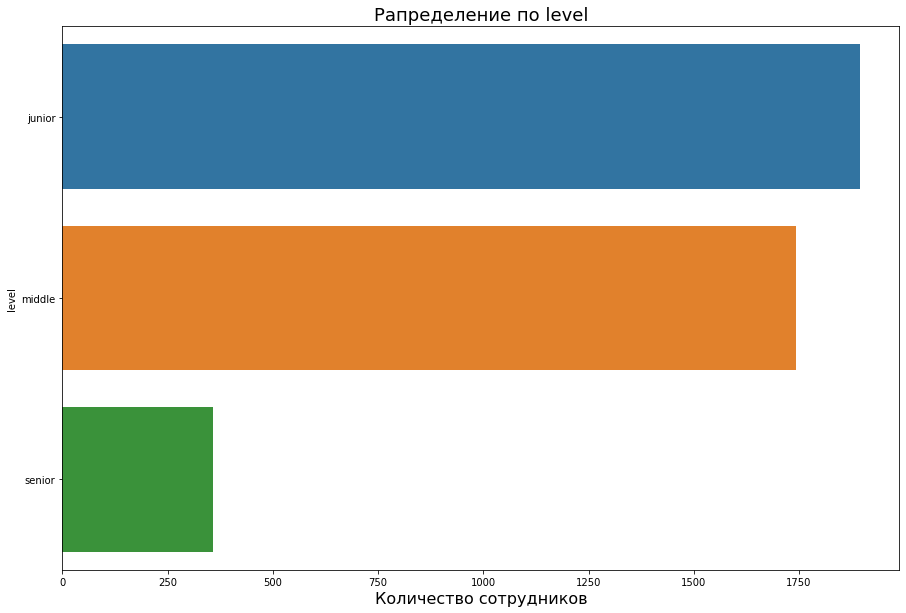

In [18]:
function_unique(train_satisfaction, 'level')

Больше всего сотрудников на позиции *junior*, далее *middle* и *sinior*

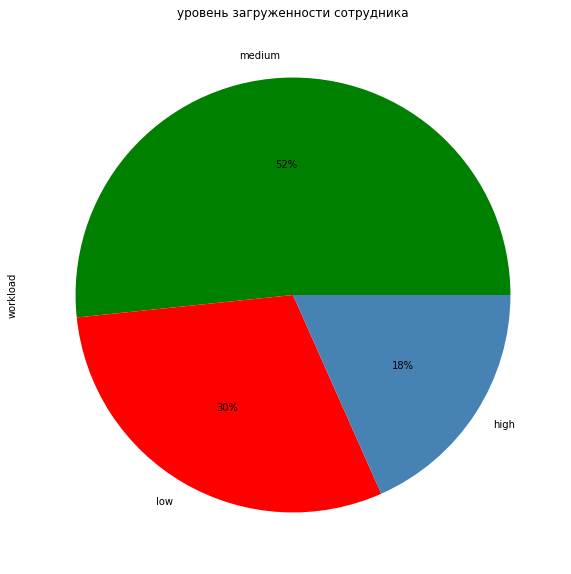

In [19]:
train_satisfaction['workload'].value_counts().plot(title='уровень загруженности сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

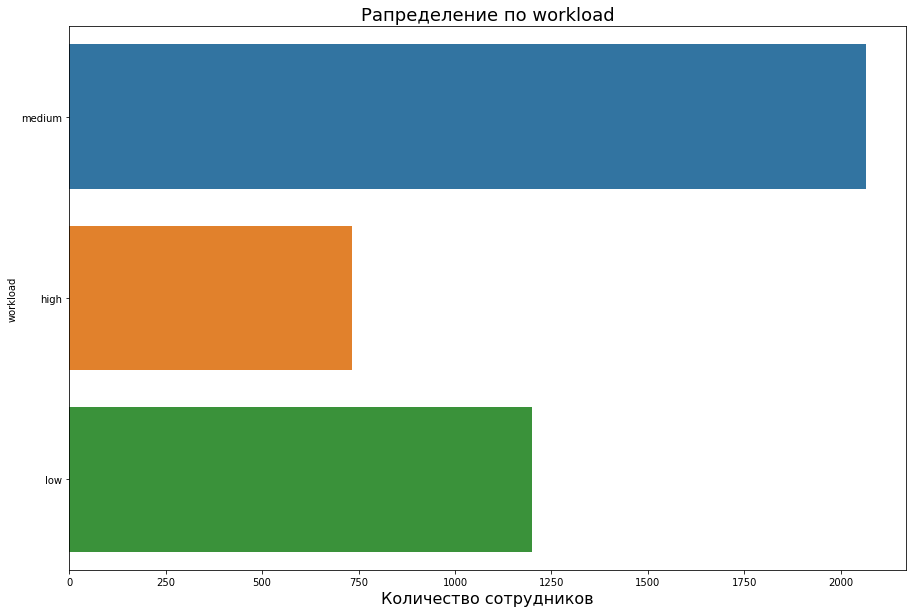

In [20]:
function_unique(train_satisfaction, 'workload')

Больше всего сотрудников имеют среднюю загруженность, далее небольшую загруженность и последние самую высокую

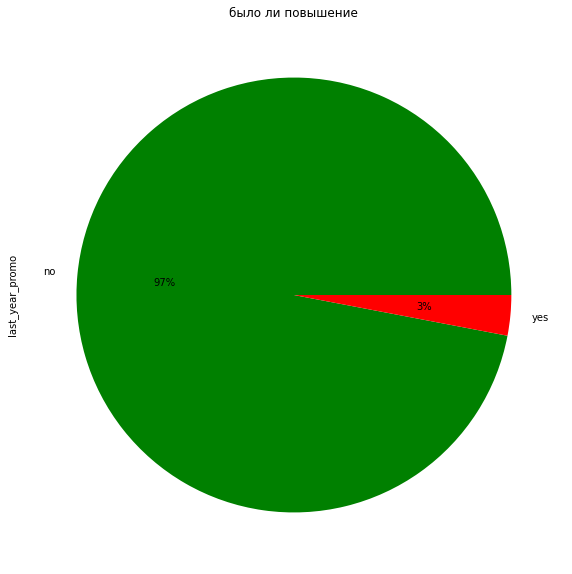

In [21]:
train_satisfaction['last_year_promo'].value_counts().plot(title='было ли повышение',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

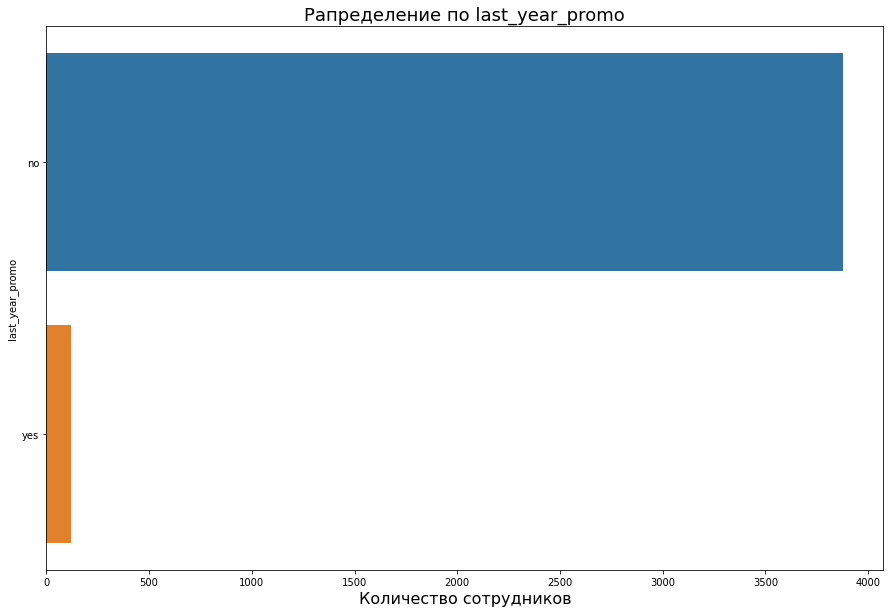

In [22]:
function_unique(train_satisfaction, 'last_year_promo')

У большей части сотрудников,а именно 97% не было повышения за последний год,и лишь у 3% оно было

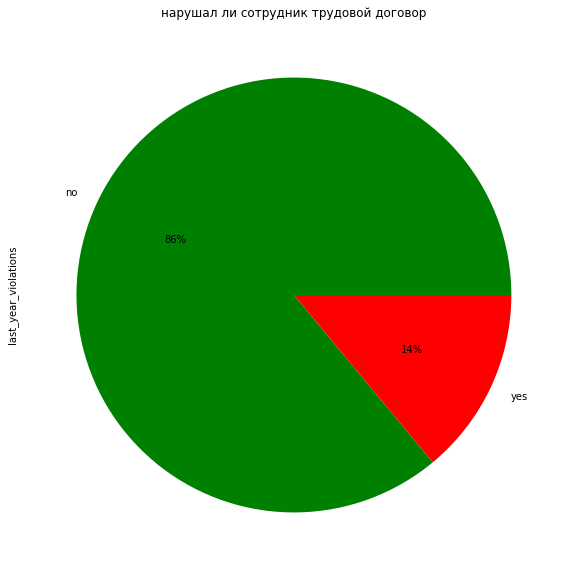

In [23]:
train_satisfaction['last_year_violations'].value_counts().plot(title='нарушал ли сотрудник трудовой договор',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

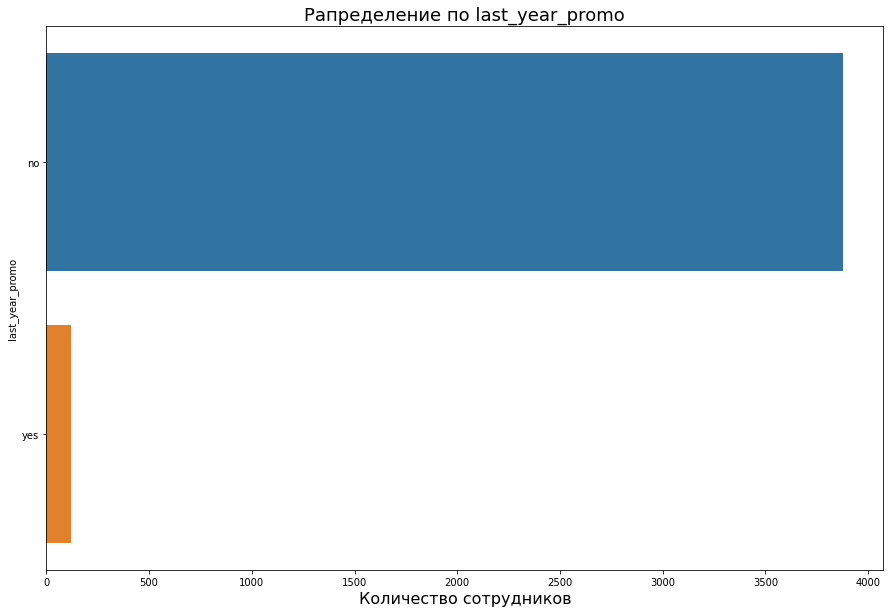

In [24]:
function_unique(train_satisfaction, 'last_year_promo')

14% сотрудников нарушали трудовой договор

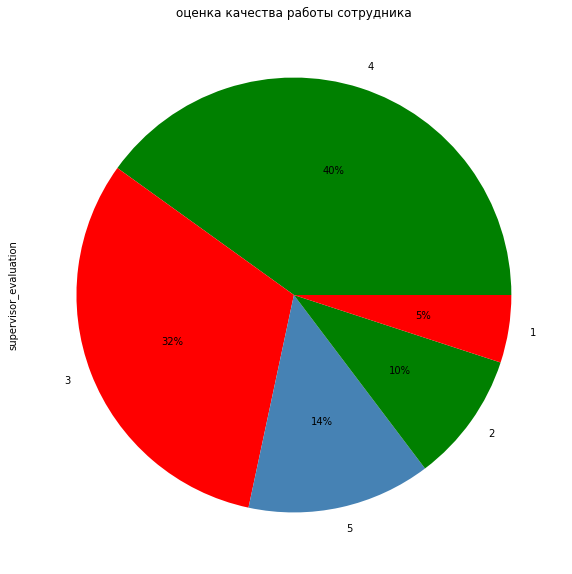

In [25]:
train_satisfaction['supervisor_evaluation'].value_counts().plot(title='оценка качества работы сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

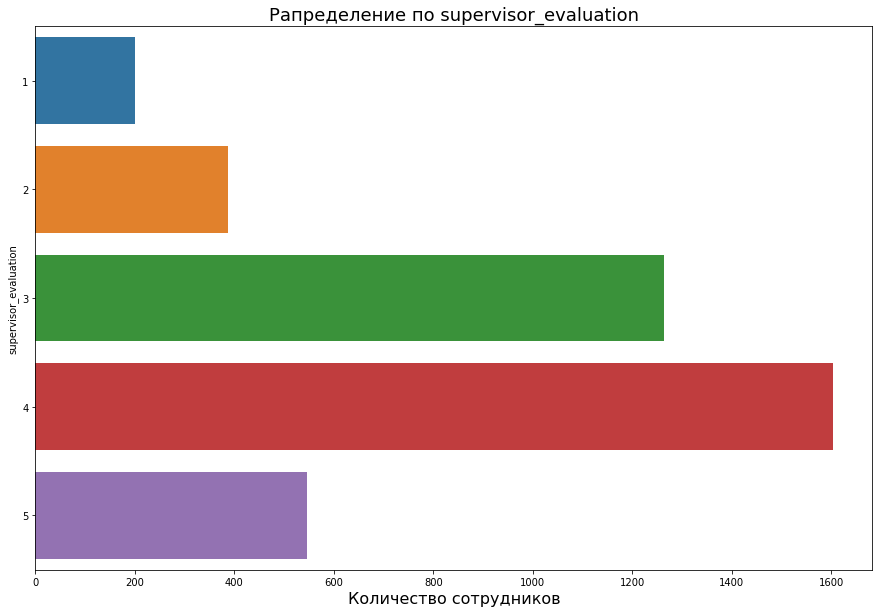

In [26]:
function_unique(train_satisfaction, 'supervisor_evaluation')

Небольшая часть сотрудников получили плохую оценку качества работы(15%), большая часть имеют положительные оценки, самая большая часть(85%) получили оценку выше среднего

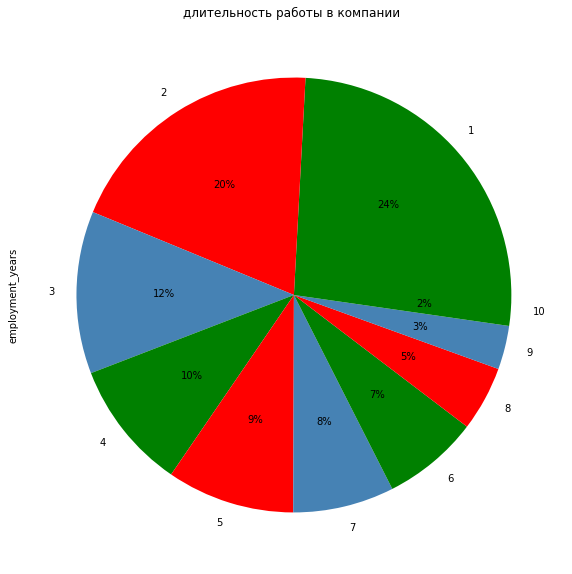

In [27]:
train_satisfaction['employment_years'].value_counts().plot(title='длительность работы в компании ',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

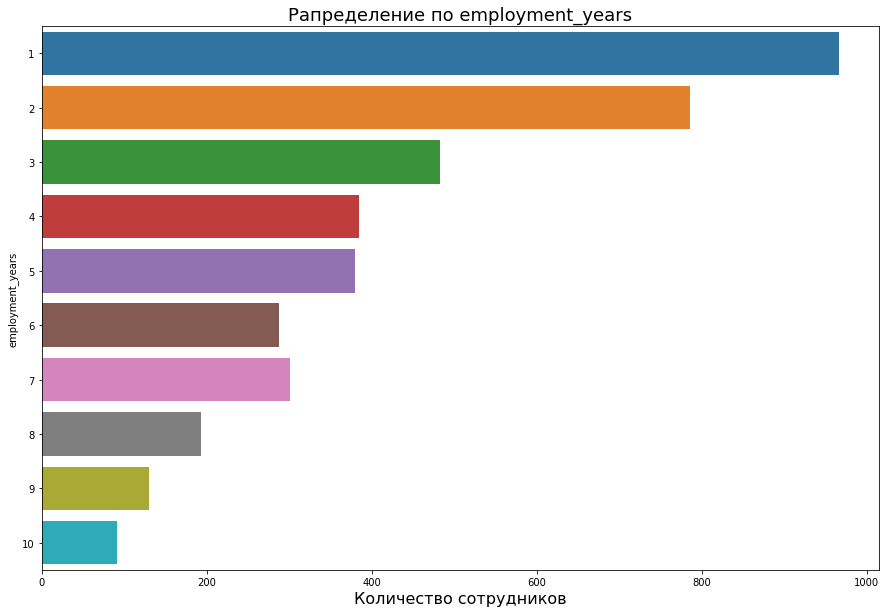

In [28]:
function_unique(train_satisfaction, 'employment_years')

Самое большое количество сотрудников работают один год,далее количество сотрудников уменьшается с ростом количества лет в компании

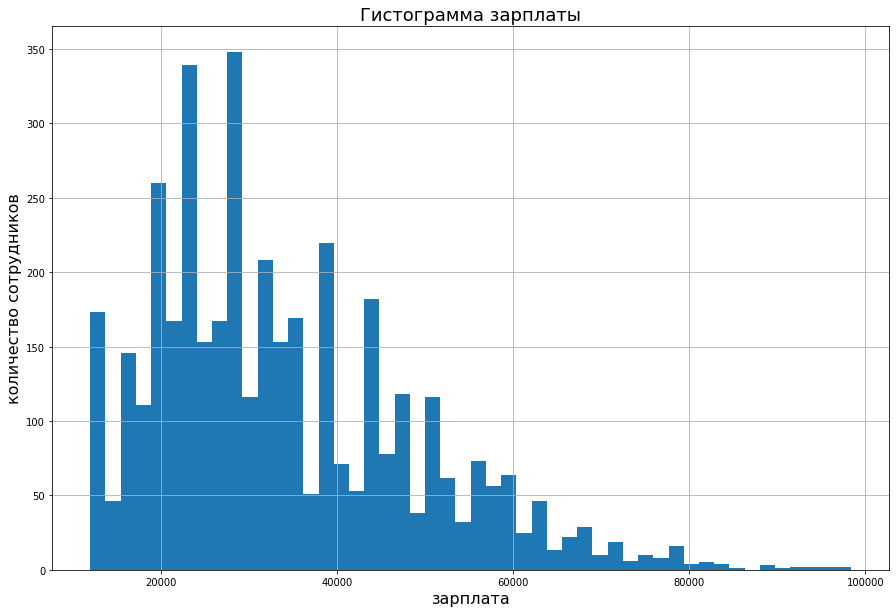

In [29]:
hist = train_satisfaction.salary.hist(bins=50) 
  
plt.title('Гистограмма зарплаты', fontsize=18) 
plt.xlabel('зарплата', fontsize=16) 
plt.ylabel('количество сотрудников', fontsize=16) 
   
plt.show() 

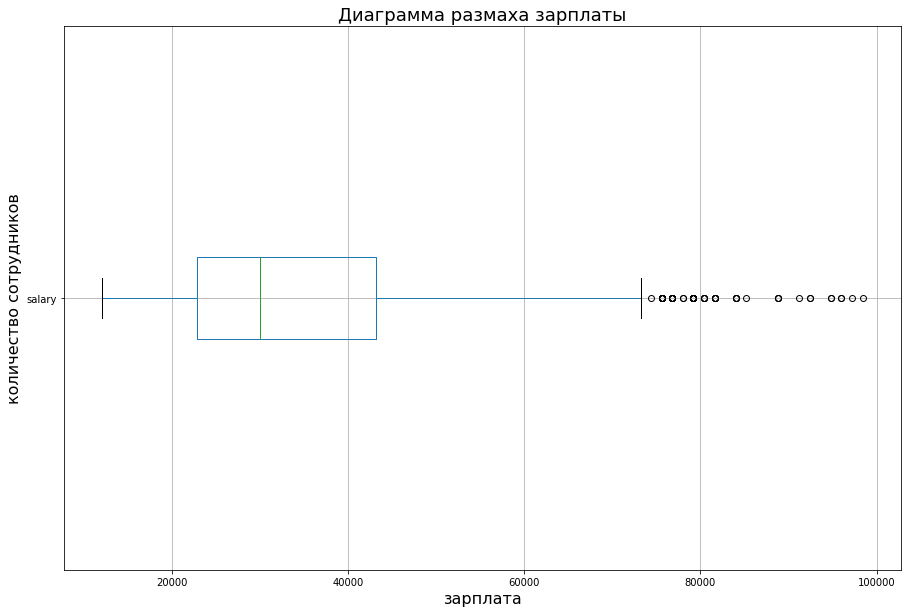

In [30]:
train_satisfaction.boxplot(column=['salary'], grid=True, vert=False)

plt.title('Диаграмма размаха зарплаты', fontsize=18)
plt.xlabel('зарплата', fontsize=16) 
plt.ylabel('количество сотрудников', fontsize=16) 

plt.show()

In [31]:
train_satisfaction.query('salary > 80000')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
45,538347,technology,senior,high,3,no,no,1,84000,0.21
141,128304,marketing,senior,high,7,no,no,3,80400,0.48
360,405345,marketing,senior,high,7,no,no,2,81600,0.58
1241,148024,technology,senior,high,4,no,no,4,94800,0.67
1718,712878,purchasing,senior,high,9,no,yes,4,80400,0.66
1799,494125,marketing,senior,high,10,no,no,4,84000,0.81
1855,355174,technology,senior,high,6,no,yes,4,88800,0.74
1899,642094,technology,senior,high,6,no,no,5,88800,0.83
1981,961485,technology,senior,high,9,no,no,3,84000,0.40
1982,978915,technology,senior,high,7,no,no,1,92400,0.45


Большое колличество зарплат до 60 тысяч,т.к большее количество сотрудников работают год и *junior*, с зарпдатой больше 80000 *sinior* с большой загруженностью

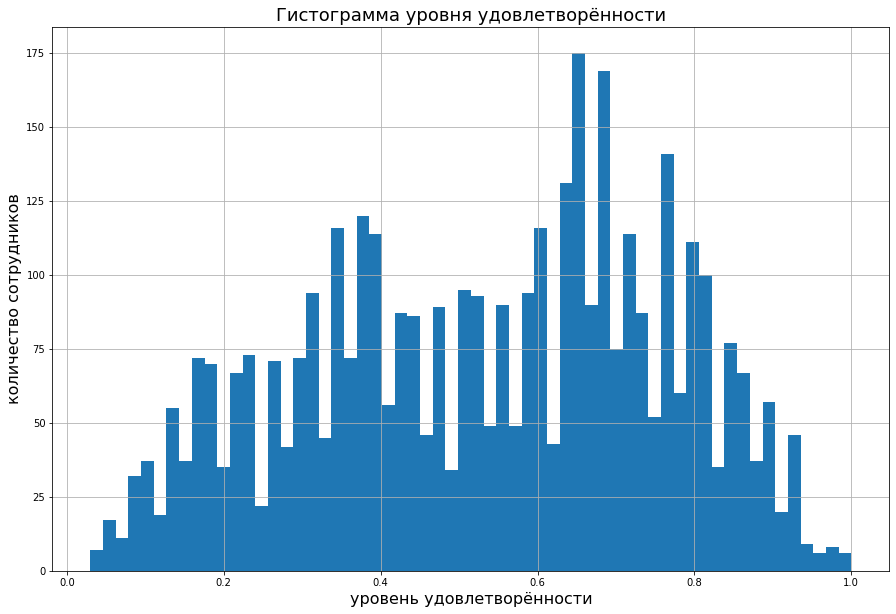

In [32]:
hist = train_satisfaction.job_satisfaction_rate.hist(bins=60) 
  
plt.title('Гистограмма уровня удовлетворённости', fontsize=18) 
plt.xlabel('уровень удовлетворённости', fontsize=16) 
plt.ylabel('количество сотрудников', fontsize=16) 
   
plt.show()

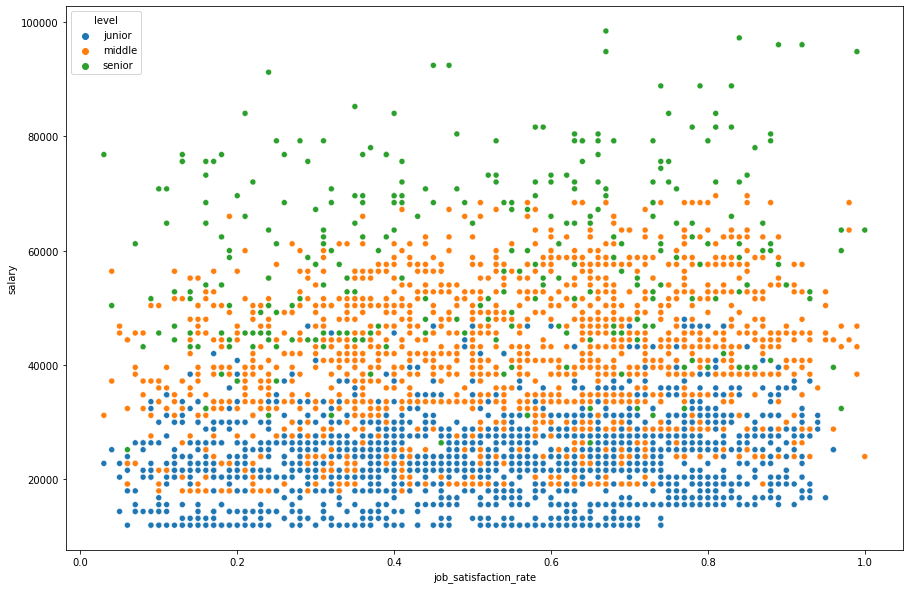

In [33]:
sns.scatterplot(data=train_satisfaction, x='job_satisfaction_rate', y='salary', hue = 'level');

Посмотрел на график зависимости *зарплаты* от *уровеня удовлетворённости сотрудника* распределенный по уровню квалификации сотрудника, удовлетвороенность сотрудников распределена равномерно на каждом уровне занимаемой должности

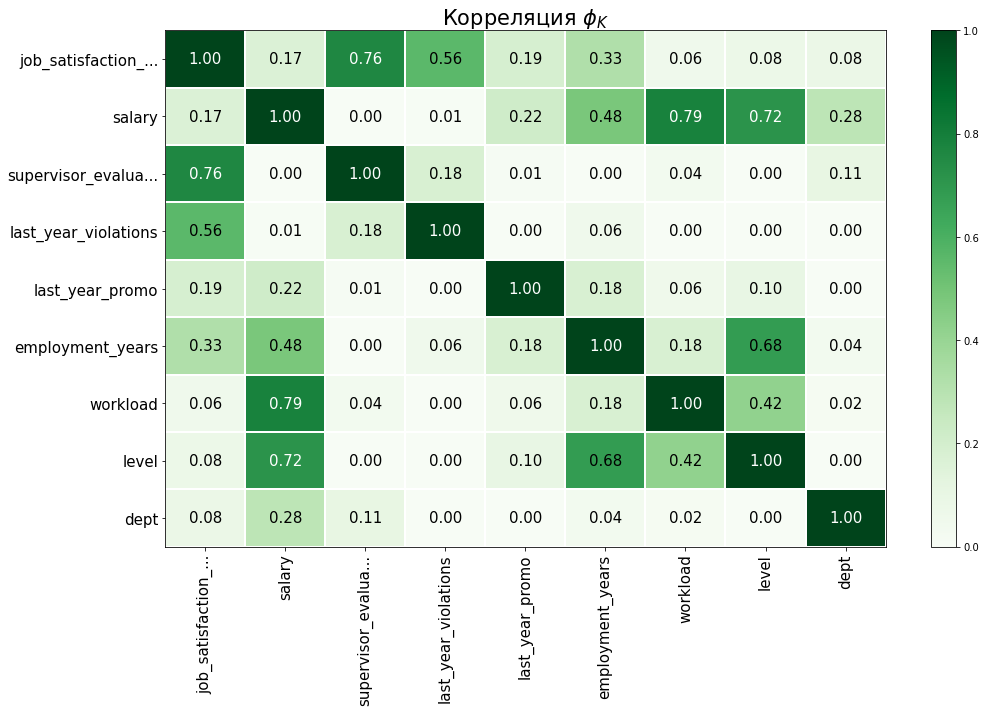

In [34]:
df_phik = train_satisfaction.drop(['id'], axis=1)

interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Построил матрицу корреляции phik, наблюдаю зависимость *зарплаты* от *загруженности* и *уровня*, также *уровень удовлетворённости сотрудника* от *оценки качества работы сотрудника, которую дал руководитель*, и *уровень* от *длительности работы в компании*

In [35]:
features_test_satisfaction.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,2000.0,NaN,NaN,NaN,552765.2135,253851.326129,100298.0,339052.0,550793.0,765763.75,999029.0
dept,1997,5,sales,763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,1999,3,junior,974,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,1999,3,medium,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,2000.0,NaN,NaN,NaN,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
last_year_promo,2000,2,no,1937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,2000,2,no,1738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,2000.0,NaN,NaN,NaN,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,NaN,NaN,NaN,34066.8,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


Вывел основные статистические характеристики данных столбца *features_test_satisfaction*

In [36]:
display(features_test_satisfaction[features_test_satisfaction.dept.isnull()])
display(features_test_satisfaction[features_test_satisfaction.workload.isnull()])
features_test_satisfaction[features_test_satisfaction.level.isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800
1699,822186,NaN,middle,medium,3,no,no,4,38400


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,NaN,4,no,no,4,28800


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


Посмотрел на строки с пропусками в данных, здесь также нет данных об уровне сотрудника в отделе продаж, нет информации об уровне загруженности сотрудника отдела марнетинга и нет информации об отделах в которых работаю 3 сотрудника

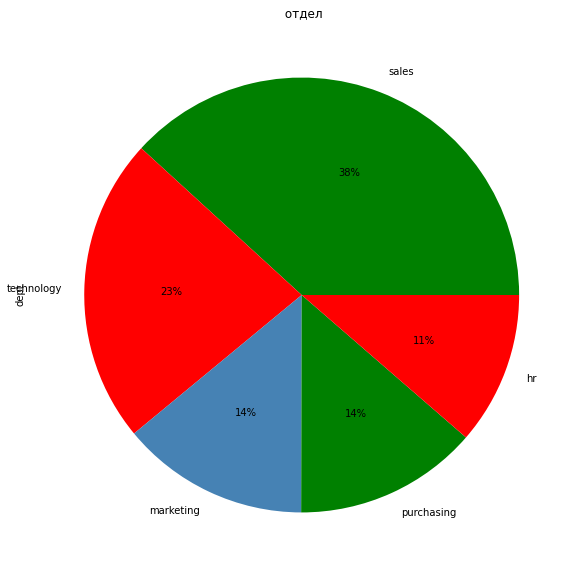

In [37]:
features_test_satisfaction['dept'].value_counts().plot(title=' отдел',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

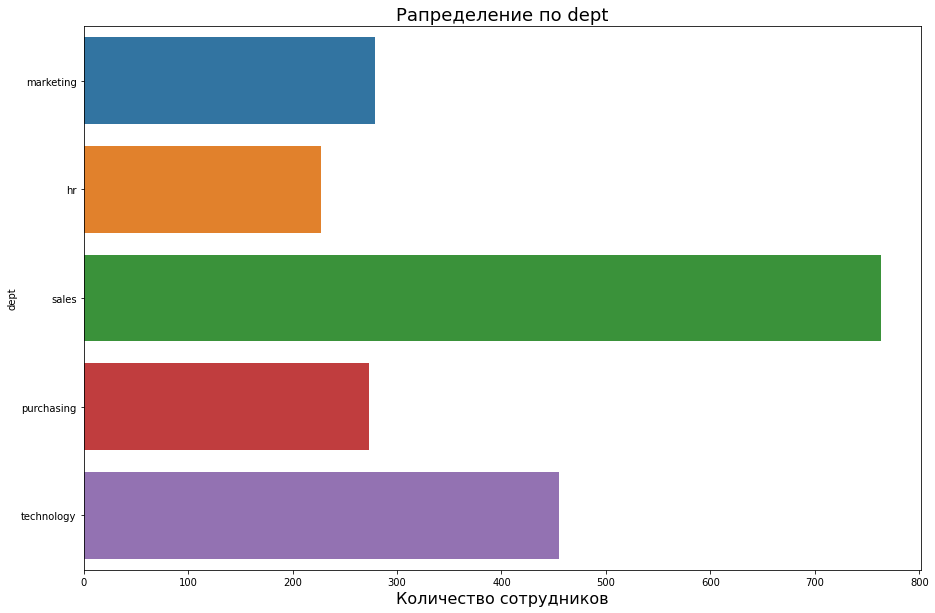

In [38]:
function_unique(features_test_satisfaction, 'dept')

Тут также в лидерах отдел *продаж*

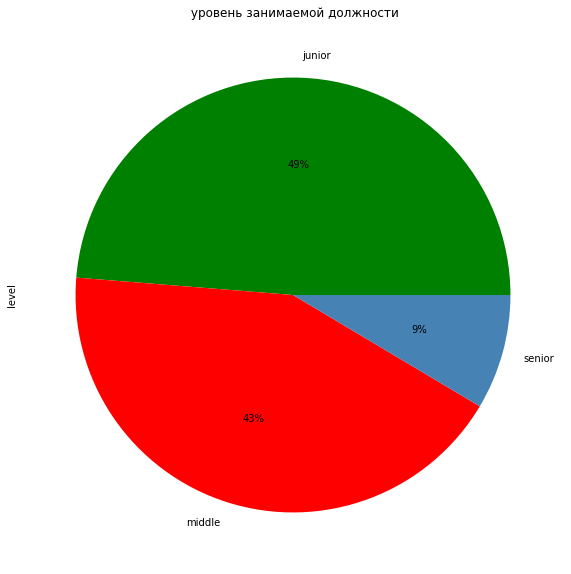

In [39]:
features_test_satisfaction['level'].value_counts().plot(title=' уровень занимаемой должности',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

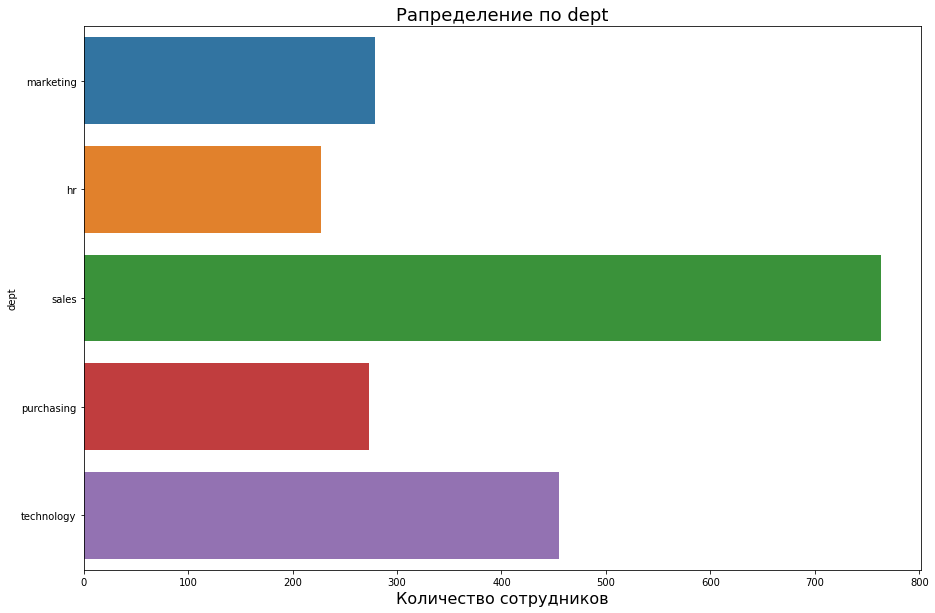

In [40]:
function_unique(features_test_satisfaction, 'dept')

Больше всего сотрудников на позиции *junior*

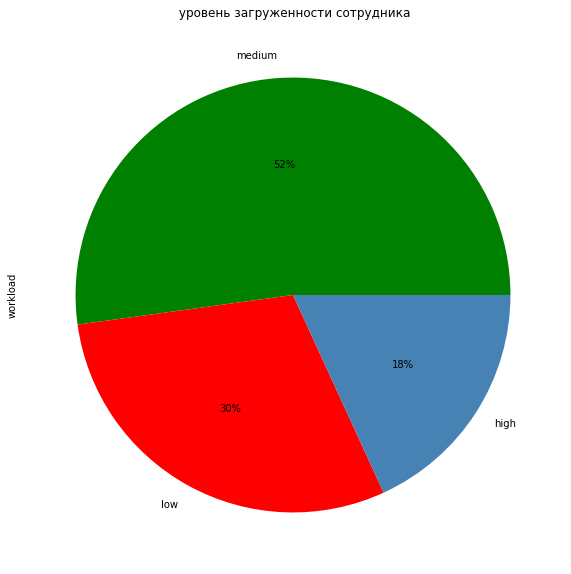

In [41]:
features_test_satisfaction['workload'].value_counts().plot(title=' уровень загруженности сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

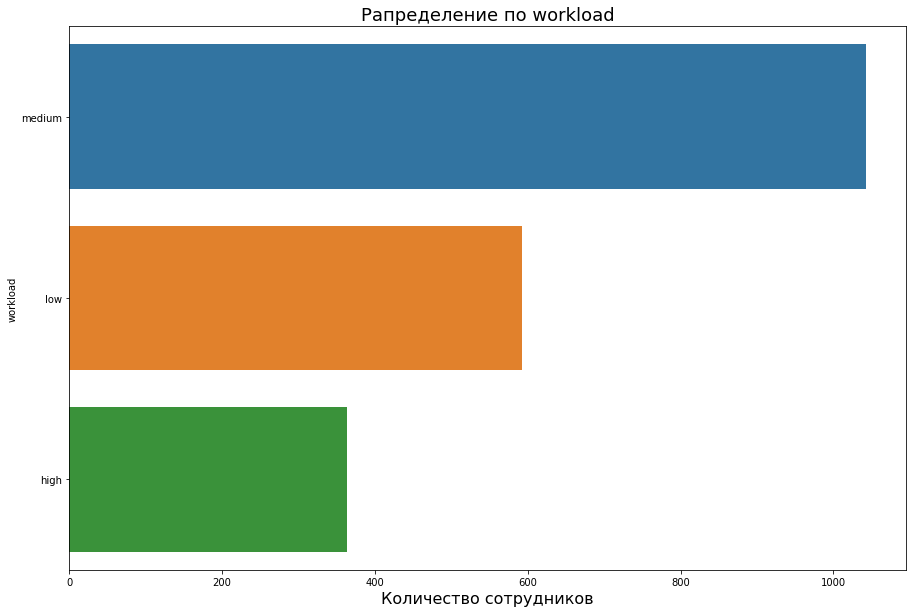

In [42]:
function_unique(features_test_satisfaction, 'workload')

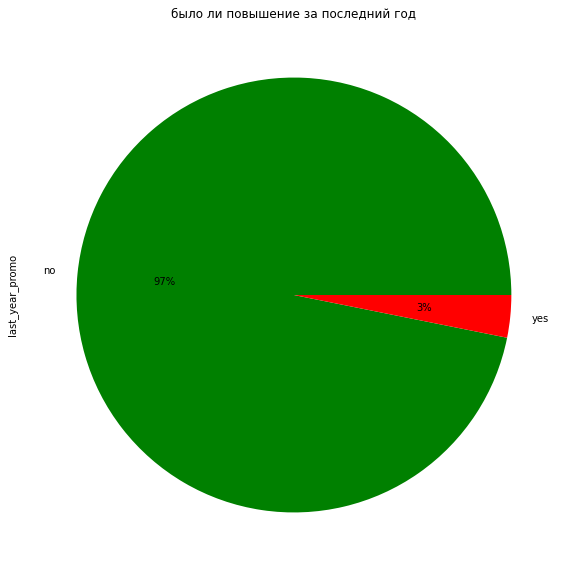

In [43]:
features_test_satisfaction['last_year_promo'].value_counts().plot(title='было ли повышение за последний год',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

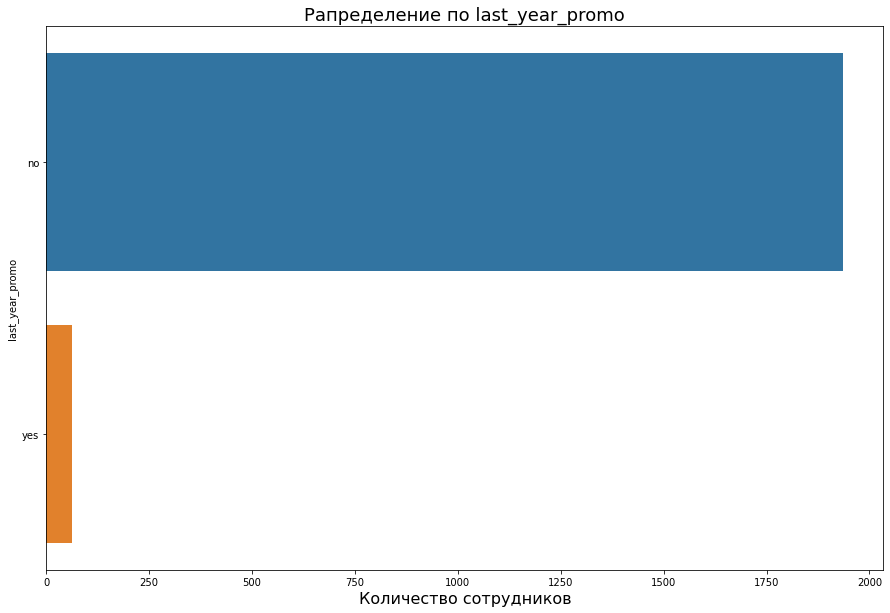

In [44]:
function_unique(features_test_satisfaction, 'last_year_promo')

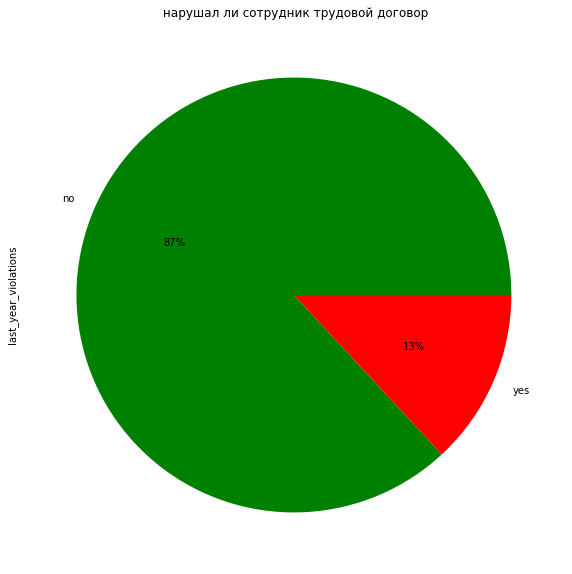

In [45]:
features_test_satisfaction['last_year_violations'].value_counts().plot(title=' нарушал ли сотрудник трудовой договор',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

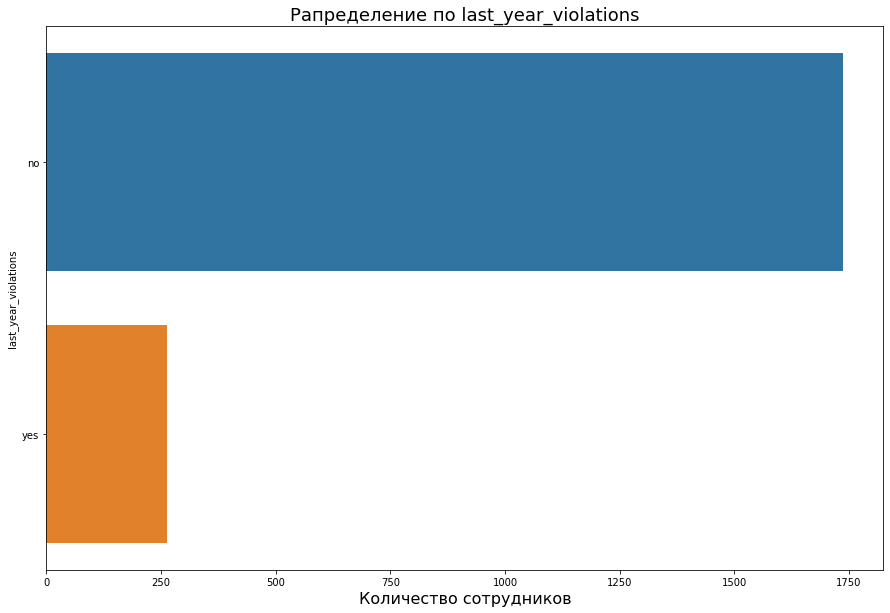

In [46]:
function_unique(features_test_satisfaction, 'last_year_violations')

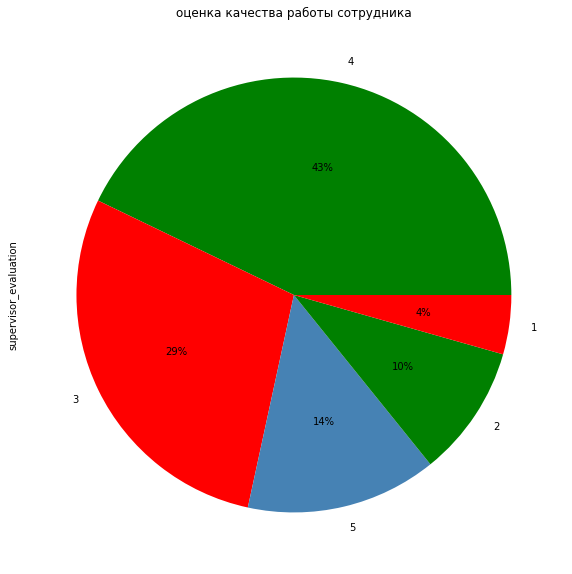

In [47]:
features_test_satisfaction['supervisor_evaluation'].value_counts().plot(title='оценка качества работы сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

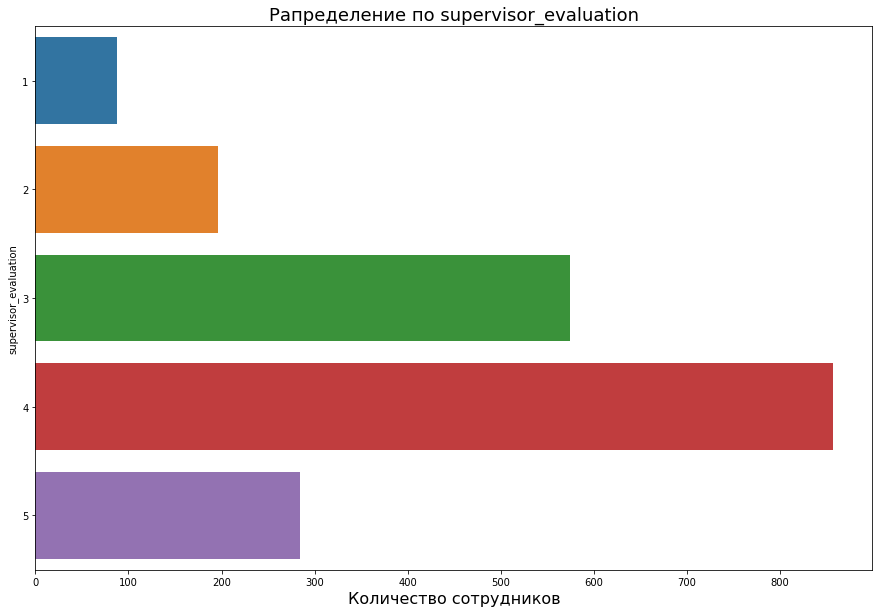

In [48]:
function_unique(features_test_satisfaction, 'supervisor_evaluation')

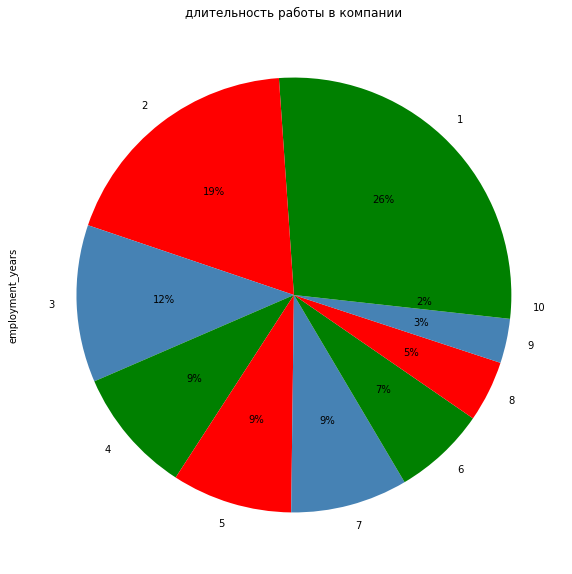

In [49]:
features_test_satisfaction['employment_years'].value_counts().plot(title='длительность работы в компании',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

Данные в столбца *employment_years*, *supervisor_evaluation*, *last_year_violations*, *last_year_promo*, *workload*  распределены так же как в тренировочных

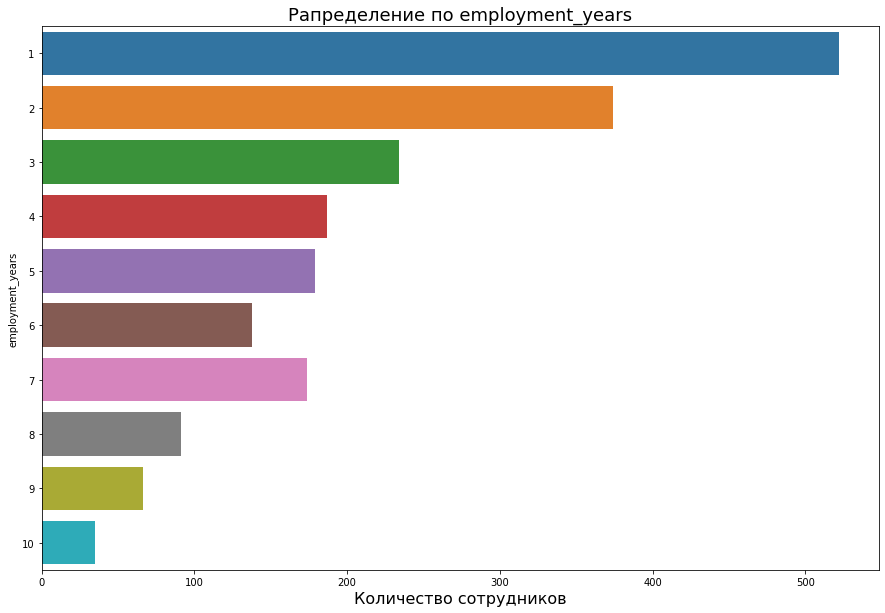

In [50]:
function_unique(features_test_satisfaction, 'employment_years')

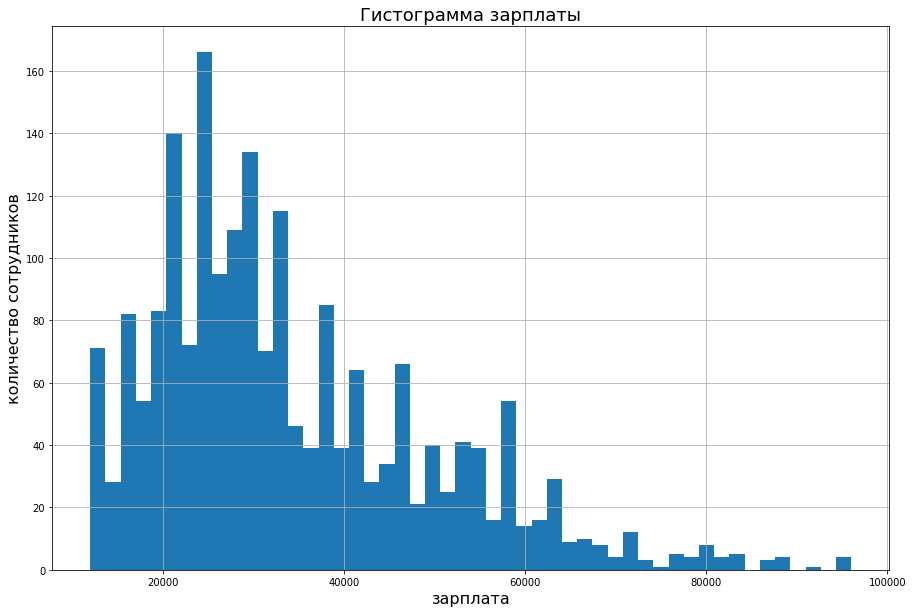

In [51]:
hist = features_test_satisfaction.salary.hist(bins=50) 
  
plt.title('Гистограмма зарплаты', fontsize=18) 
plt.xlabel('зарплата', fontsize=16) 
plt.ylabel('количество сотрудников', fontsize=16) 
   
plt.show()

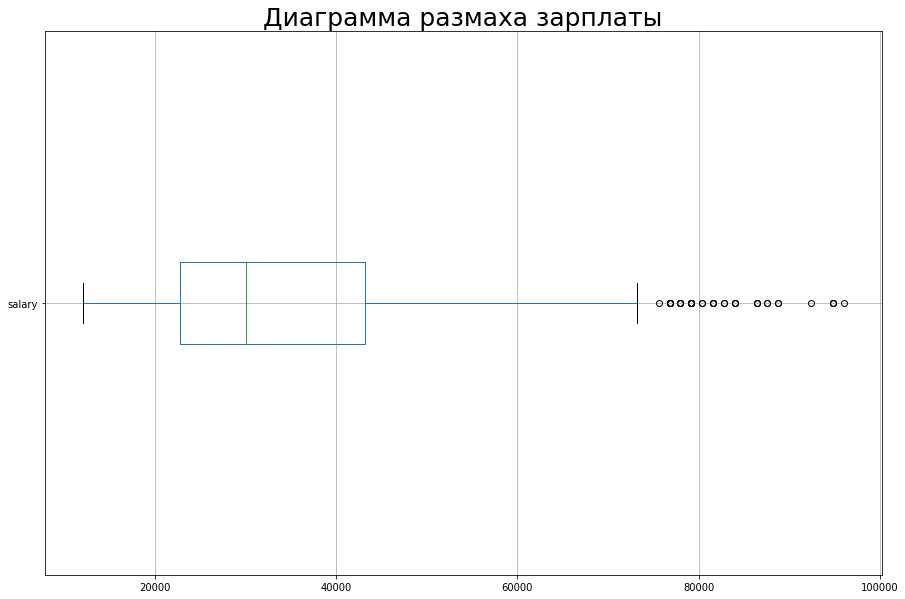

In [52]:
features_test_satisfaction.boxplot(column=['salary'], grid=True, vert=False)
plt.title('Диаграмма размаха зарплаты', size=25);
plt.show()

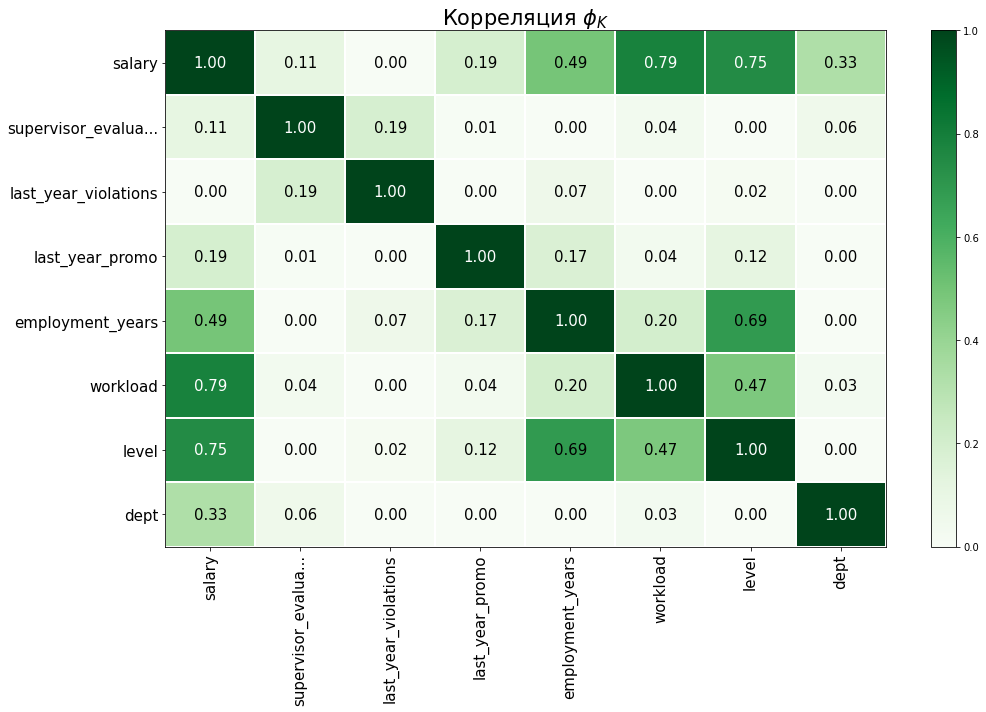

In [53]:
df_phik = features_test_satisfaction.drop(['id'], axis=1)

interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Построил матрицу корреляции phik, наблюдаю зависимость зарплаты от загруженности и уровня, также уровень от длительности работы в компании

**Вывод подготовки данных:**

Делим признаки на способы кодировки и численные масштабируем:
- dept, last_year_promo, last_year_violations — кодирую с помощью OneHotEncoder.
- level, workload — кодирую с помощью OrdinalEncoder, так как они имеют уровни.
- employment_years, supervisor_evaluation, salary - масштабировирую.

Пропуски обработую в пайплайне.

Убрав столбец *id*, появятся дубликаты в таблицах, их предется удалить.

## Шаг. Подготовка данных

In [54]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload']

num_columns = ['salary', 
               'employment_years', 
               'supervisor_evaluation']

In [55]:
target_features_test_satisfaction = target_test_satisfaction.merge(features_test_satisfaction, on='id', how='left')

In [56]:
train = train_satisfaction.drop(['id'], axis=1)
train.duplicated().sum()

245

In [57]:
train.drop_duplicates(inplace=True)

features_test = target_features_test_satisfaction.drop(['job_satisfaction_rate','id'], axis=1)

target_test = target_features_test_satisfaction['job_satisfaction_rate'] 

In [58]:
RANDOM_STATE = 42

X_train = train.drop('job_satisfaction_rate', axis=1)
y_train = train['job_satisfaction_rate'] 
X_test = features_test
y_test = target_test

In [59]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(3755, 8)
(2000, 8)
(3755,)
(2000,)


In [60]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [61]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])
 
param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [62]:
def smape_func(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denumerator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(numerator / denumerator) * 100

smape_scorer = make_scorer(score_func=smape_func, greater_is_better=False)

In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring=smape_scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train);

In [64]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
8,0.307988,1,DecisionTreeRegressor(random_state=42),-15.997397,"{'preprocessor__num': StandardScaler(), 'models__max_features': 13, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
1,0.436967,2,DecisionTreeRegressor(random_state=42),-16.360776,"{'preprocessor__num': 'passthrough', 'models__max_features': 7, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
9,0.689149,3,DecisionTreeRegressor(random_state=42),-16.472313,"{'preprocessor__num': 'passthrough', 'models__max_features': 12, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
4,0.333936,4,DecisionTreeRegressor(random_state=42),-16.855603,"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
0,0.363505,5,DecisionTreeRegressor(random_state=42),-17.684816,"{'preprocessor__num': StandardScaler(), 'models__max_features': 5, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
6,0.665446,6,DecisionTreeRegressor(random_state=42),-18.246259,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}"
2,0.702181,7,DecisionTreeRegressor(random_state=42),-18.310228,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
3,1.032114,8,DecisionTreeRegressor(random_state=42),-19.436137,"{'preprocessor__num': 'passthrough', 'models__max_features': 2, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
5,0.713896,9,DecisionTreeRegressor(random_state=42),-22.681929,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=42)}"
7,0.704934,10,DecisionTreeRegressor(random_state=42),-22.697173,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=42)}"


In [65]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025073,0.001262,0.009688,0.000714,StandardScaler(),5,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 5, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}",-17.062540,-17.845516,-17.898195,-18.101571,-17.516261,-17.684816,0.363505,5
1,0.022580,0.001114,0.007973,0.000212,passthrough,7,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 7, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",-16.400835,-15.640689,-16.623307,-16.942685,-16.196366,-16.360776,0.436967,2
2,0.022965,0.000465,0.008967,0.000274,MinMaxScaler(),3,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}",-18.762638,-17.418249,-17.554563,-19.207566,-18.608122,-18.310228,0.702181,7
3,0.019993,0.000443,0.007974,0.000140,passthrough,2,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 2, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}",-18.800510,-18.179549,-21.005946,-20.240376,-18.954304,-19.436137,1.032114,8
4,0.020677,0.000200,0.007955,0.000272,passthrough,6,11,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 6, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}",-16.680895,-16.453400,-16.983213,-17.432430,-16.728076,-16.855603,0.333936,4
5,0.021586,0.000765,0.008725,0.000130,MinMaxScaler(),6,3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=42)}",-23.203349,-21.992240,-23.706003,-22.693204,-21.814847,-22.681929,0.713896,9
6,0.023024,0.001614,0.009136,0.000210,MinMaxScaler(),4,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}",-18.949753,-17.225707,-18.108501,-19.000572,-17.946764,-18.246259,0.665446,6
7,0.023906,0.003380,0.009964,0.001689,MinMaxScaler(),13,3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 13, 'models__max_depth': 3, 'models': DecisionTreeRegressor(random_state=42)}",-23.227282,-21.992240,-23.706003,-22.693204,-21.867136,-22.697173,0.704934,10
8,0.025882,0.000693,0.009323,0.000257,StandardScaler(),13,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'models__max_features': 13, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}",-15.892863,-15.499345,-16.313427,-16.333505,-15.947848,-15.997397,0.307988,1
9,0.022205,0.000399,0.008002,0.000105,passthrough,12,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__max_features': 12, 'models__max_depth': 10, 'models': DecisionTreeRegressor(random_state=42)}",-16.232108,-15.308173,-16.859552,-17.364601,-16.597131,-16.472313,0.689149,3


In [66]:
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_)


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                           

Лучшей моделью оказалось *дерево решений*, с гиперпараметрами max_depth=14, max_features=13 и маштабированием StandardScaler()

In [67]:
print(f'Метрика SMAPE лучшей модели на кросс-валидации: {round(randomized_search.best_score_*(-1),2)}')

Метрика SMAPE лучшей модели на кросс-валидации: 16.0


In [68]:
model = randomized_search.best_estimator_

In [69]:
y_pred = model.predict(X_test)

In [70]:
print(f'Метрика SMAPE на тестовой выборке: {round(smape_func(y_test, y_pred),2)}')

Метрика SMAPE на тестовой выборке: 14.48


**Выводы:** Кодировали данные с помощью OneHotEncoder и OrdinalEncoder,масштабировали с MinMaxScaler() и StandardScaler() в пайплане, обичили модель на тренировочной выборки, инструментом для автоматизированного поиска гиперпараметров был RandomizedSearchCV().Лучшей моделью оказалось дерево решений, с гиперпараметрами max_depth=14, max_features=13 и маштабированием StandardScaler()

Метрика SMAPE на тренировочных показала результат 16, Метрика SMAPE на тестовых данных показала результат 14.48

# Задача 2: предсказание увольнения сотрудника из компании

## Шаг. Загрузка данных

In [71]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=',')
    features_test_quit = pd.read_csv('/datasets/test_features.csv', sep=',')
    target_test_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=',')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', sep=',')
    features_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', sep=',')
    target_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', sep=',')

In [72]:
display(train_quit.head())
display(features_test_quit.head())
target_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [73]:
display(train_quit.info())
display(features_test_quit.info())
target_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Вывод: Загрузил данные, имеем 3 таблицы.Первая с тренировочными включая целевой признак,вторая с тестовыми признаками и третья таблица с целевым признаком тестовой выборки.Наблюдаю пропуски в данных, которые буду обрабатывать в пайплане.

## Шаг. Предобработка данных

In [74]:
display(train_quit.duplicated().sum())
display(features_test_quit.duplicated().sum())
target_test_quit.duplicated().sum()

0

0

0

Дубликатов нет

In [75]:
for column in train_quit.columns:
    unique_count = train_quit[column].nunique()
    unique_values = train_quit[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 4000 unique values:
[723290 814010 155091 ... 536432 692133 853842]
Столбец 'dept' имеет 5 unique values:
['sales' 'purchasing' 'marketing' 'technology' 'hr']
Столбец 'level' имеет 3 unique values:
['middle' 'junior' 'sinior']
Столбец 'workload' имеет 3 unique values:
['high' 'medium' 'low']
Столбец 'employment_years' имеет 10 unique values:
[ 2  5  1  8  4  7  3  9  6 10]
Столбец 'last_year_promo' имеет 2 unique values:
['no' 'yes']
Столбец 'last_year_violations' имеет 2 unique values:
['no' 'yes']
Столбец 'supervisor_evaluation' имеет 5 unique values:
[4 1 3 5 2]
Столбец 'salary' имеет 69 unique values:
[54000 27600 37200 24000 25200 18000 44400 19200 45600 57600 33600 16800
 22800 26400 82800 32400 39600 30000 46800 12000 15600 58800 60000 66000
 21600 38400 62400 40800 56400 34800 28800 52800 20400 36000 61200 48000
 43200 73200 31200 78000 64800 72000 94800 96000 63600 79200 55200 42000
 49200 50400 14400 13200 51600 67200 88800 68400 69600 70800 84000 81600
 87

In [76]:
train_quit['level'] = train_quit['level'].str.replace('sinior', 'senior')

In [77]:
for column in features_test_quit.columns:
    unique_count = features_test_quit[column].nunique()
    unique_values = features_test_quit[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 2000 unique values:
[485046 686555 467458 ... 305653 160233 771859]
Столбец 'dept' имеет 6 unique values:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Столбец 'level' имеет 3 unique values:
['junior' 'middle' 'sinior' nan]
Столбец 'workload' имеет 4 unique values:
['medium' 'low' 'high' ' ']
Столбец 'employment_years' имеет 10 unique values:
[ 2  1  5  6  3  9  7  4  8 10]
Столбец 'last_year_promo' имеет 2 unique values:
['no' 'yes']
Столбец 'last_year_violations' имеет 2 unique values:
['no' 'yes']
Столбец 'supervisor_evaluation' имеет 5 unique values:
[5 4 3 1 2]
Столбец 'salary' имеет 66 unique values:
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600

In [78]:
features_test_quit['dept'] = features_test_quit['dept'].replace(' ', np.nan)
features_test_quit['workload'] = features_test_quit['workload'].replace(' ', np.nan)
features_test_quit['level'] = features_test_quit['level'].str.replace('sinior', 'senior')

In [79]:
for column in target_test_quit.columns:
    unique_count = target_test_quit[column].nunique()
    unique_values = target_test_quit[column].unique()
    print(f"Столбец '{column}' имеет {unique_count} unique values:")
    print(unique_values)

Столбец 'id' имеет 2000 unique values:
[999029 372846 726767 ... 746018 247658 460332]
Столбец 'quit' имеет 2 unique values:
['yes' 'no']


Вывел уникальные значения стоблцов трех таблиц пустые значения заменил на nan

## Шаг. Исследовательский анализ данных

In [80]:
train_quit.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,4000.0,NaN,NaN,NaN,552099.28375,260158.031387,100222.0,327785.75,546673.0,781497.75,999915.0
dept,4000,5,sales,1438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
level,4000,3,junior,1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workload,4000,3,medium,2118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_years,4000.0,NaN,NaN,NaN,3.7015,2.541852,1.0,2.0,3.0,6.0,10.0
last_year_promo,4000,2,no,3887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_year_violations,4000,2,no,3455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
supervisor_evaluation,4000.0,NaN,NaN,NaN,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,NaN,NaN,NaN,33805.8,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0
quit,4000,2,no,2872,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Вывел основные статистические характеристики данных столбца *train_quit*

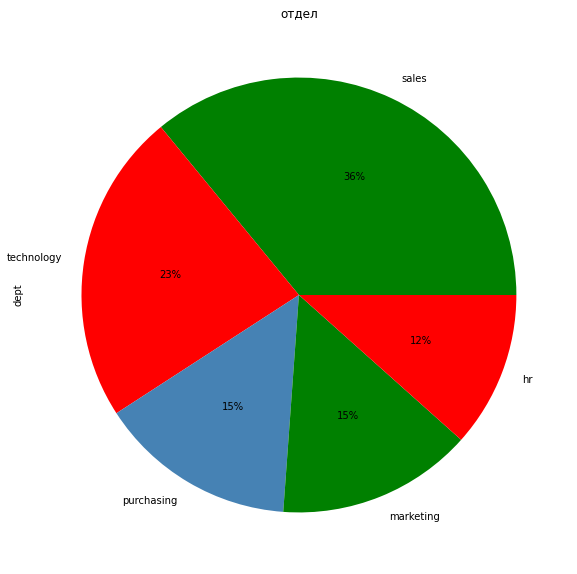

In [81]:
train_quit['dept'].value_counts().plot(title='отдел',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

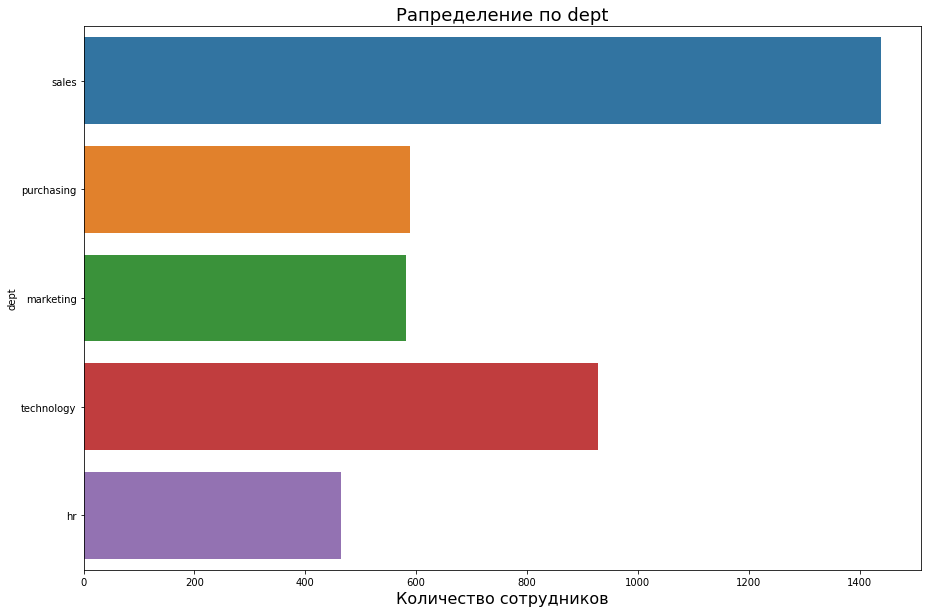

In [82]:
function_unique(train_quit, 'dept')

Больше всего сотрудников в отделе продаж,далее отдел технологий, отдел закупок, отдел маркетинга и отдел управления

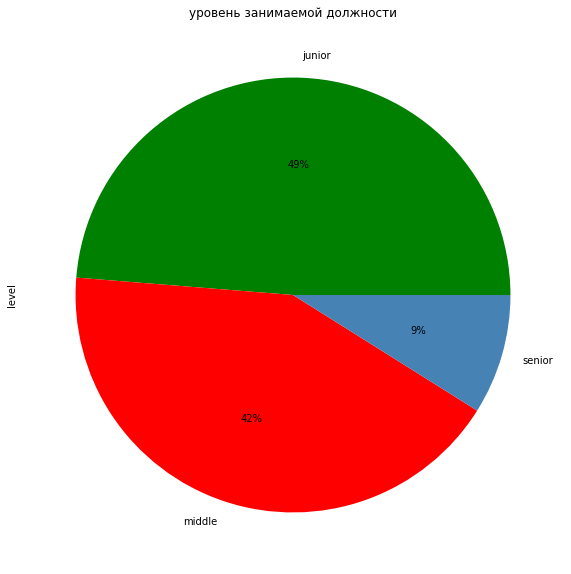

In [83]:
train_quit['level'].value_counts().plot(title='уровень занимаемой должности',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

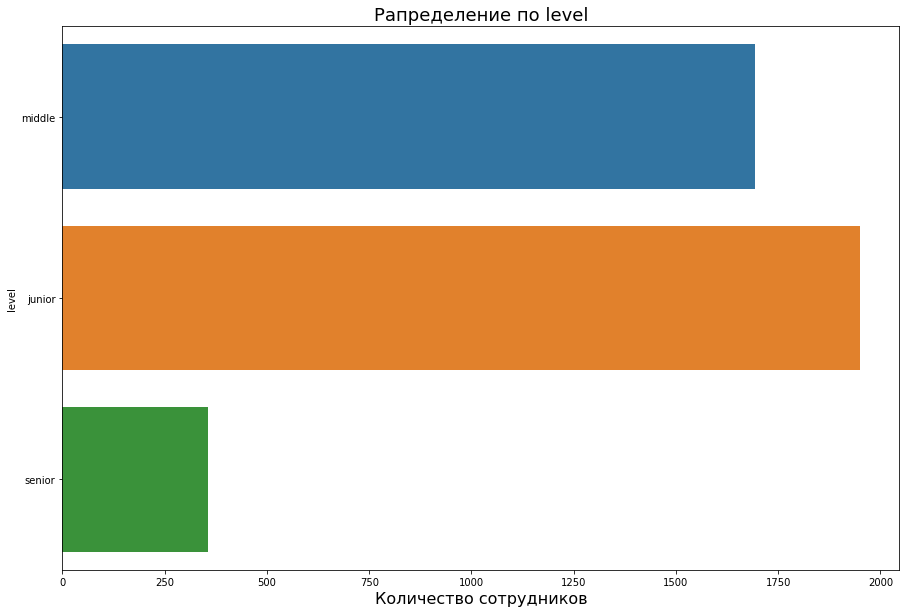

In [84]:
function_unique(train_quit, 'level')

Больше всего сотрудников с низшим уровнем *junior*

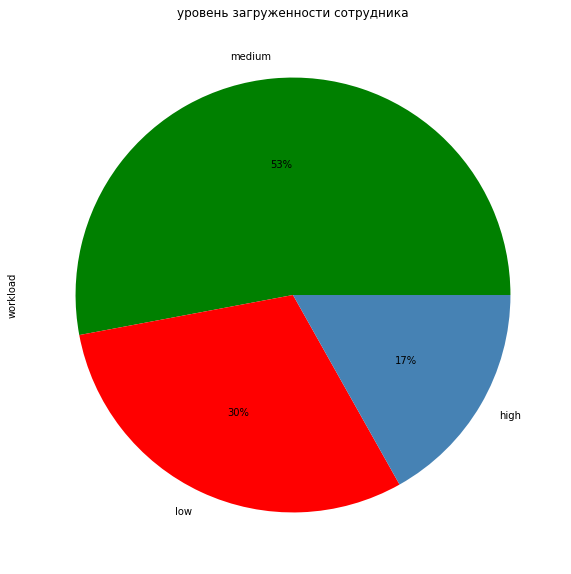

In [85]:
train_quit['workload'].value_counts().plot(title='уровень загруженности сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

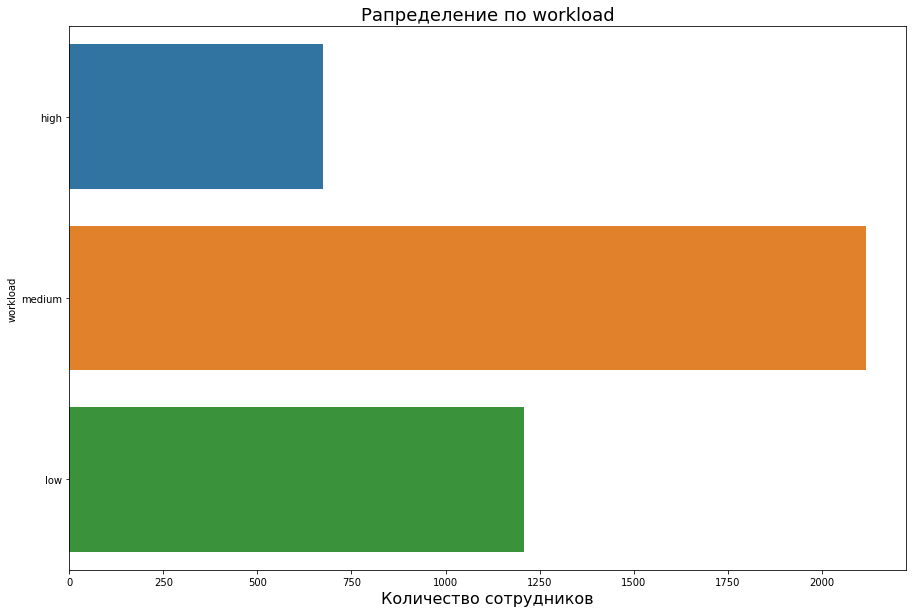

In [86]:
function_unique(train_quit, 'workload')

больше всего сотрудников со средним уровнем загруженности

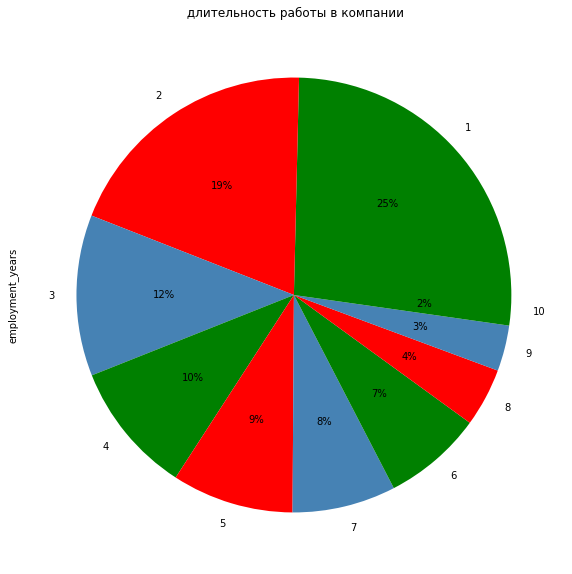

In [87]:
train_quit['employment_years'].value_counts().plot(title=' длительность работы в компании',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

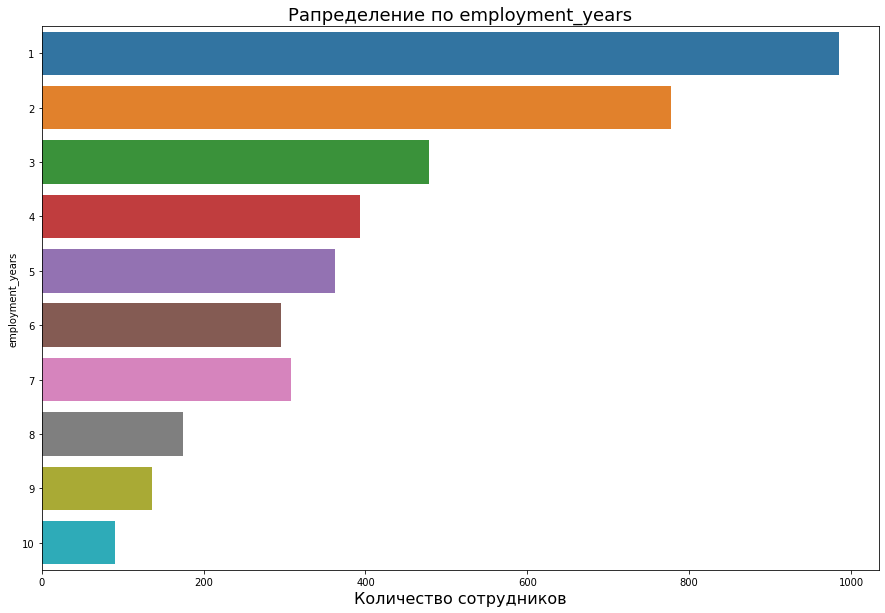

In [88]:
function_unique(train_quit, 'employment_years')

Самое большое количество сотрудников работают один год,далее количество сотрудников уменьшается с ростом количества лет в компании

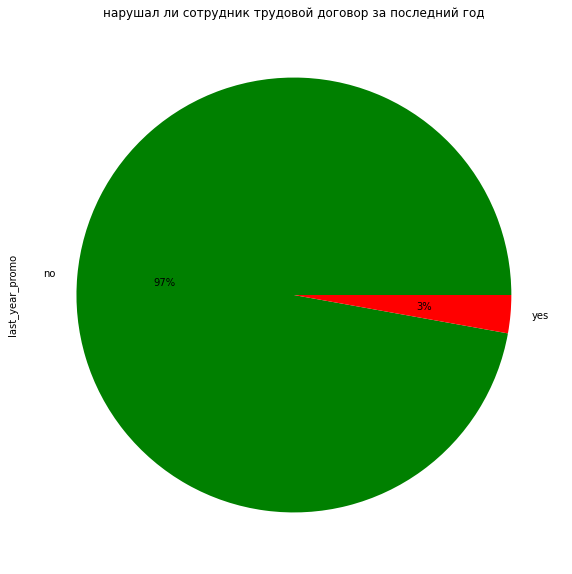

In [89]:
train_quit['last_year_promo'].value_counts().plot(title='нарушал ли сотрудник трудовой договор за последний год',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g'});

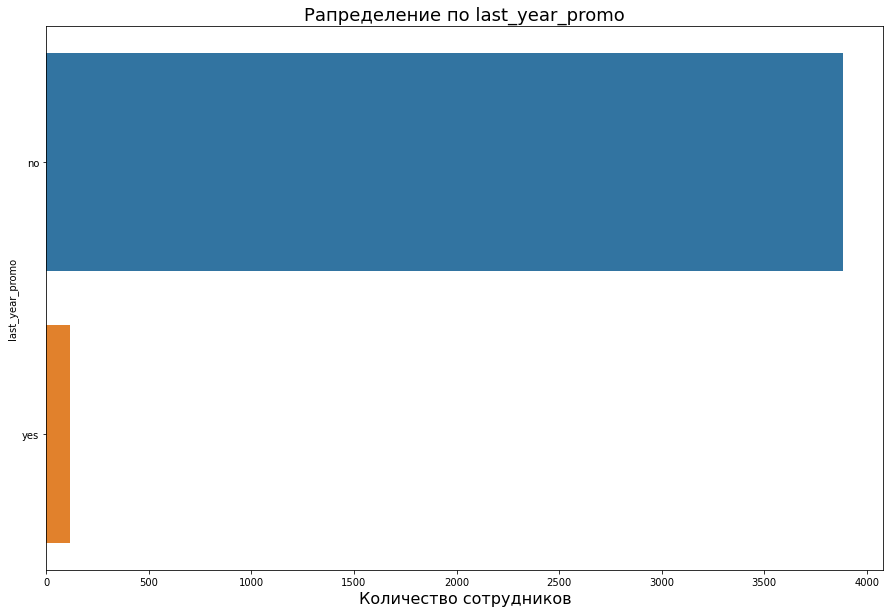

In [90]:
function_unique(train_quit, 'last_year_promo')

В данной таблице небольшое число сотрудников нарушали трудовой договор,а именно только 3%

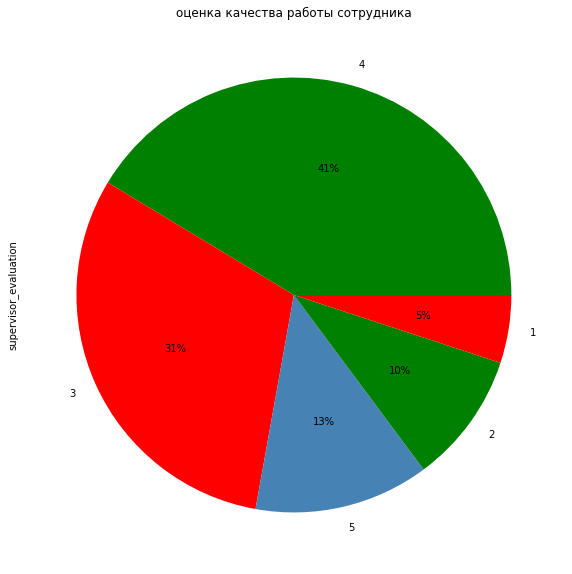

In [91]:
train_quit['supervisor_evaluation'].value_counts().plot(title='оценка качества работы сотрудника',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g', 'steelblue'});

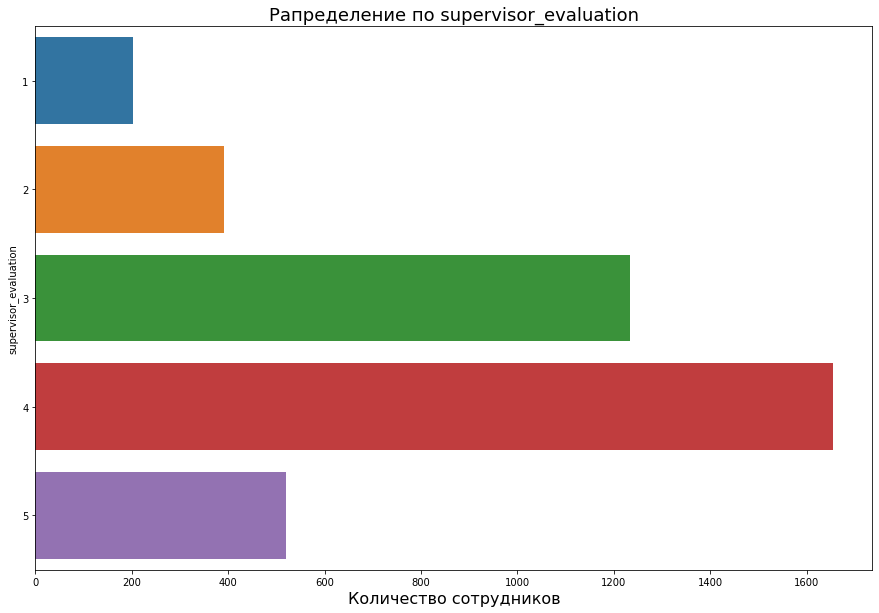

In [92]:
function_unique(train_quit, 'supervisor_evaluation')

Тут так же число сотрудников с оценкой качества работы на 4 имеет наибольшее число

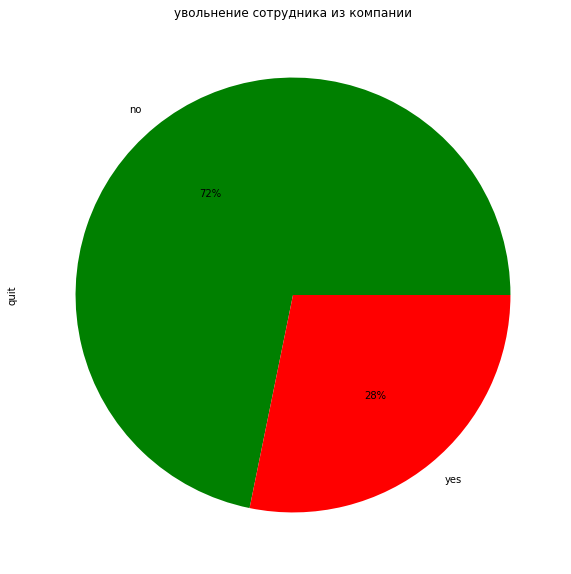

In [93]:
train_quit['quit'].value_counts().plot(title='увольнение сотрудника из компании',
    kind='pie', autopct='%1.0f%%', colors={'r', 'g'});

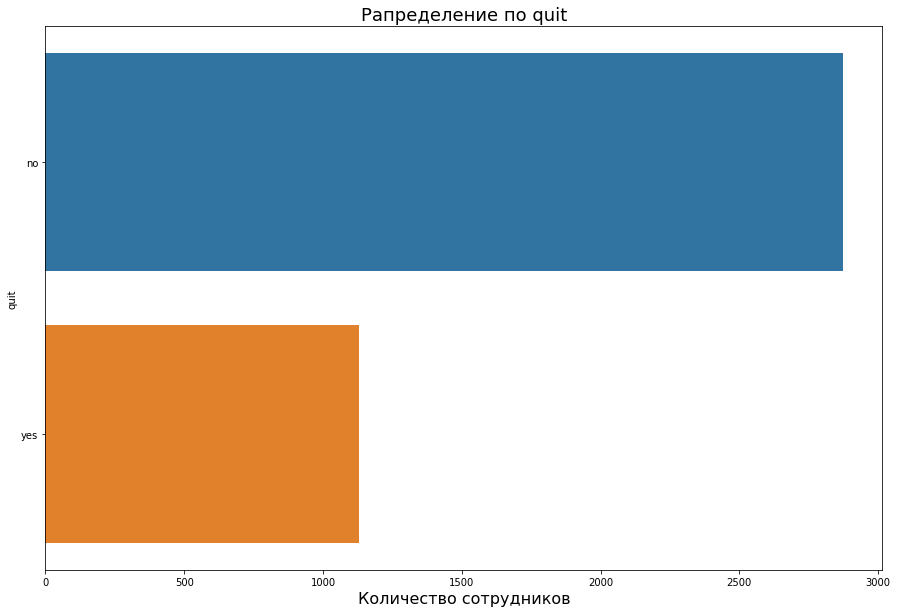

In [94]:
function_unique(train_quit, 'quit')

Соотношение уволившихся сотрудников к оставшимся примерно 1 к 3

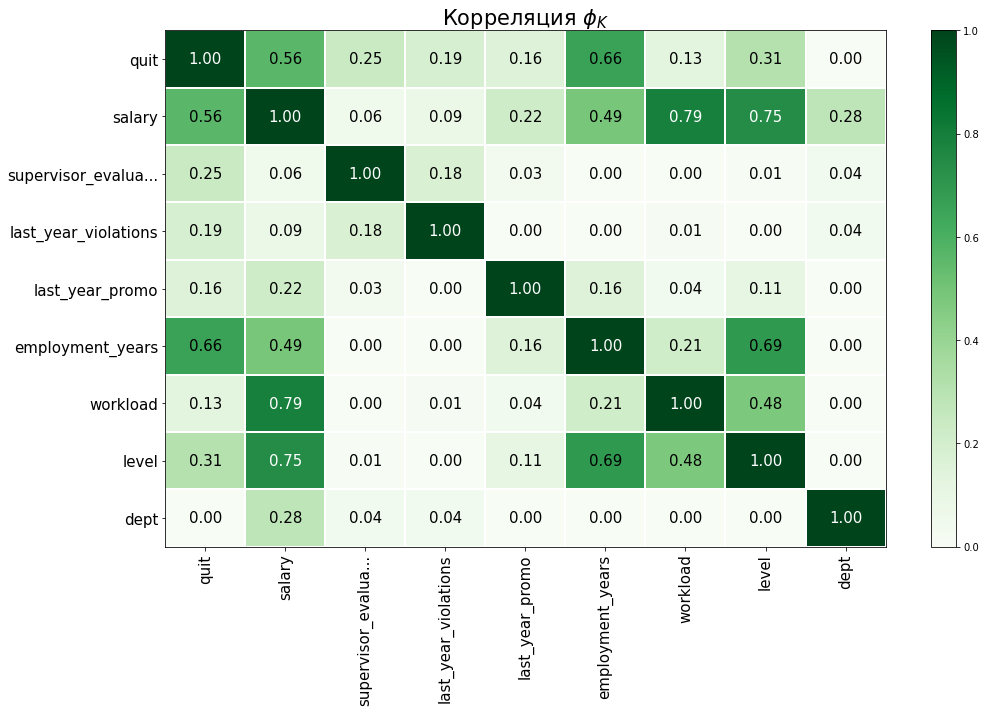

In [95]:
df_phik = train_quit.drop(['id'], axis=1)

interval_cols = ['salary', 'job_satisfaction_rate']

phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Построил матрицу корреляции phik,здесь так же уровень зарплаты зависит от уровня и загрузки сотрудника, уровень от количества лет в компании и уволен сотрудник из компании и количества лет в компании

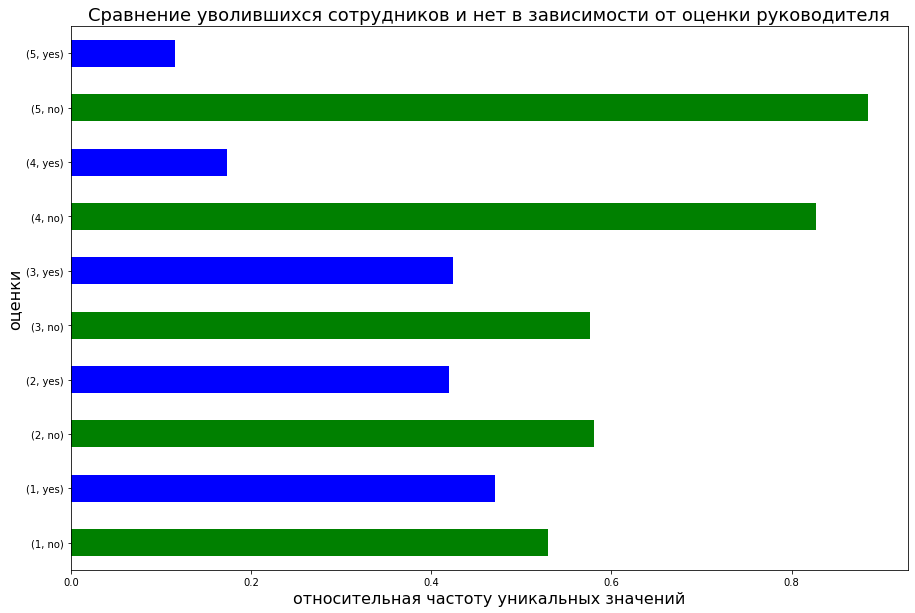

In [96]:
file_groupby = train_quit.groupby(['supervisor_evaluation'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от оценки руководителя', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('оценки', fontsize=16) 
   
plt.show()

Большая разница при оценках руководителя 4 и 5,сотрудники с такой оценкой меньше увольнялись чем с другими

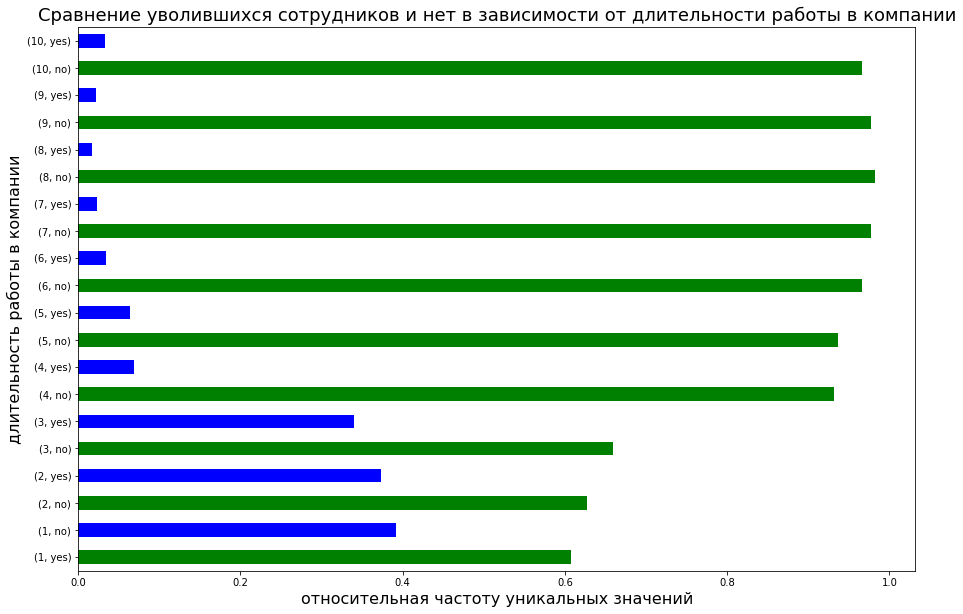

In [97]:
file_groupby = train_quit.groupby(['employment_years'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от длительности работы в компании', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('длительность работы в компании', fontsize=16) 
   
plt.show()

Ожидаемо большая разница наблюдается среди сотрудников отработавших менее 4 лет

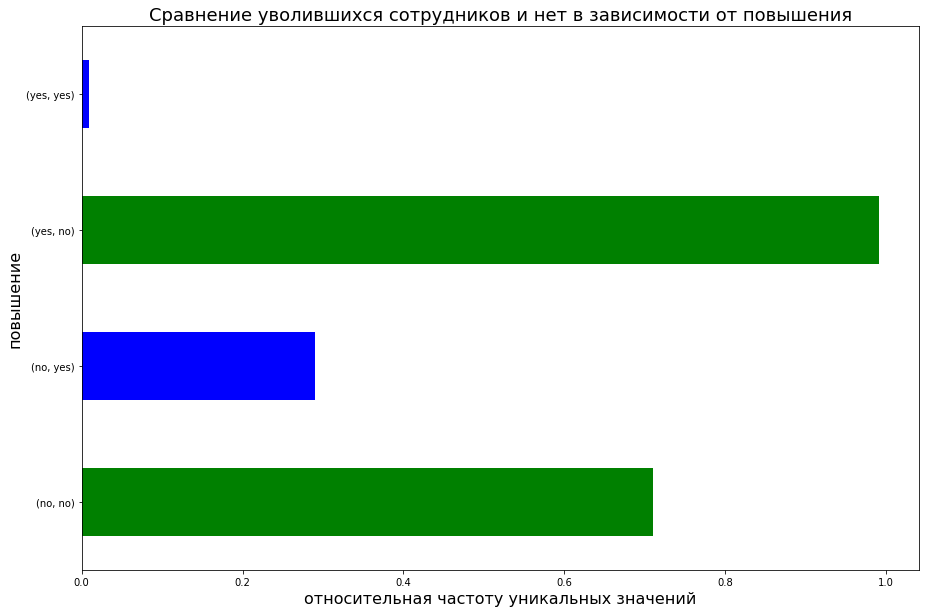

In [98]:
file_groupby = train_quit.groupby(['last_year_promo'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от повышения', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('повышение', fontsize=16) 
   
plt.show()

Зависимости нет

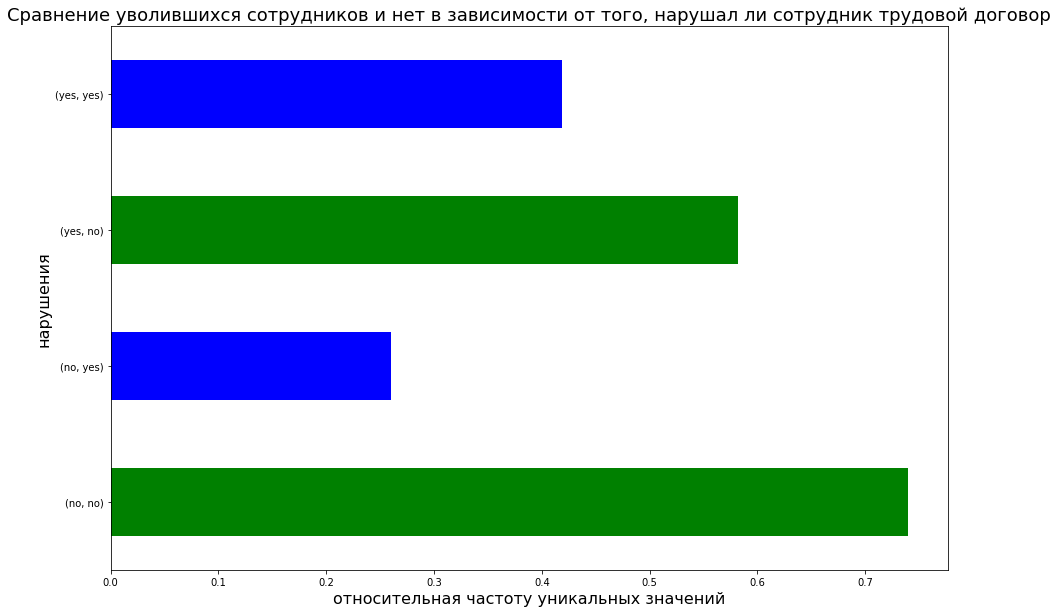

In [99]:
file_groupby = train_quit.groupby(['last_year_violations'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от того, нарушал ли сотрудник трудовой договор', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('нарушения', fontsize=16) 
   
plt.show()

Количество уволившихся сотрудников нарушавших трудовой договор, больше тех кто не нарушал

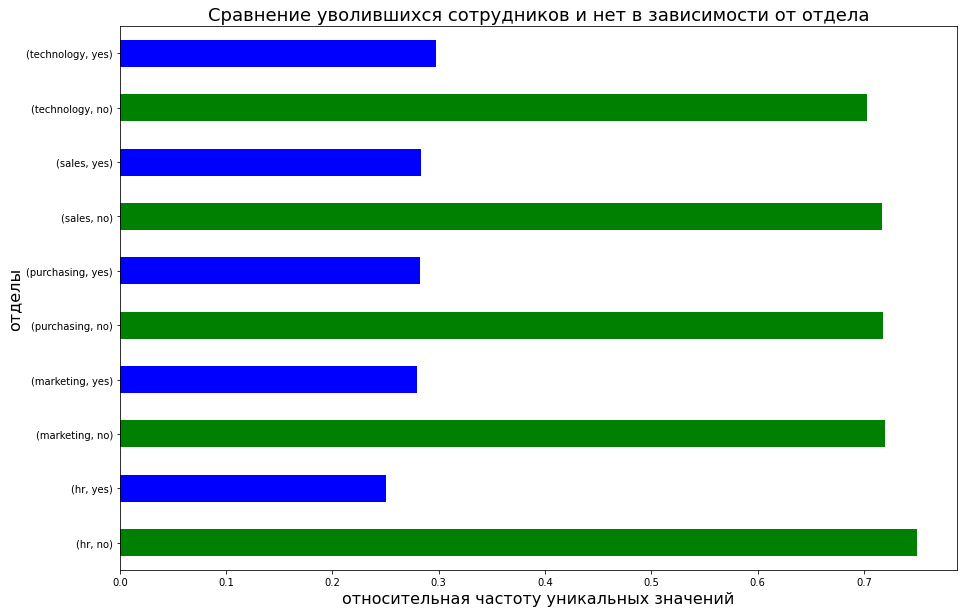

In [100]:
file_groupby = train_quit.groupby(['dept'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от отдела', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('отделы', fontsize=16) 
   
plt.show()

Таблица показывает отношение количество уволившихся сотрудников к сотрудникам которые остались, разбитых по отделам.Больше всего уволились с отдела *технологий*

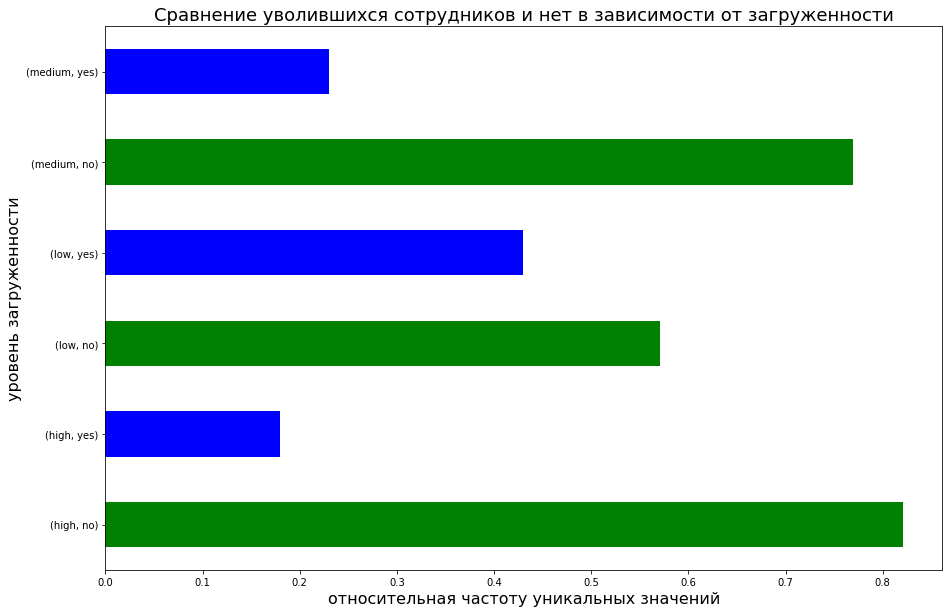

In [101]:
file_groupby = train_quit.groupby(['workload'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от загруженности', fontsize=18) 
plt.xlabel('относительная частоту уникальных значений', fontsize=16) 
plt.ylabel('уровень загруженности', fontsize=16) 
   
plt.show()

Таблица показывает отношение количество уволившихся сотрудников к сотрудникам которые остались, разбитых по *уровеню загруженности сотрудника*.Больше всего уволились самые не загруженные сотрудники

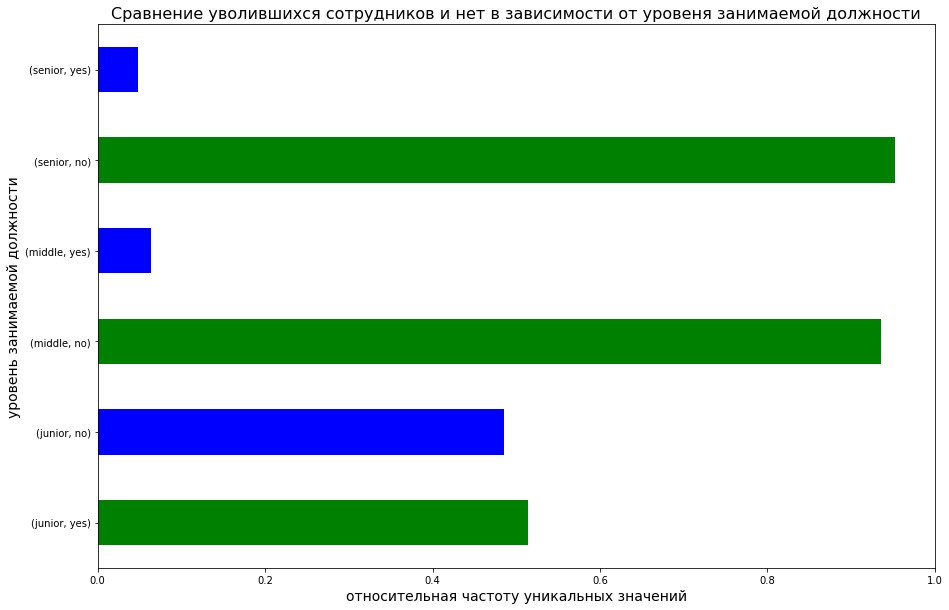

In [102]:
file_groupby = train_quit.groupby(['level'])['quit'].value_counts(normalize=True)
file_groupby.plot.barh(title='отдел',color={'g', 'b'})
plt.title('Сравнение уволившихся сотрудников и нет в зависимости от уровеня занимаемой должности', fontsize=16) 
plt.xlabel('относительная частоту уникальных значений', fontsize=14) 
plt.ylabel('уровень занимаемой должности', fontsize=14) 
   
plt.show()

Таблица показывает отношение количество уволившихся сотрудников к сотрудникам которые остались, разбитых по уровню занимаемой должности.Больше всего уволились сотрудники позиции *junior*

In [103]:
quit = train_quit['salary'][train_quit['quit'] == 'yes'].mean()
works = train_quit['salary'][train_quit['quit'] == 'no'].mean()
display(quit)
works

23885.106382978724

37702.22841225627

Зарплата сотрудников которые уволились,заметно ниже тех,кто остался

In [104]:
target_join = target_test_satisfaction.merge(target_test_quit, how ='inner', on ='id')

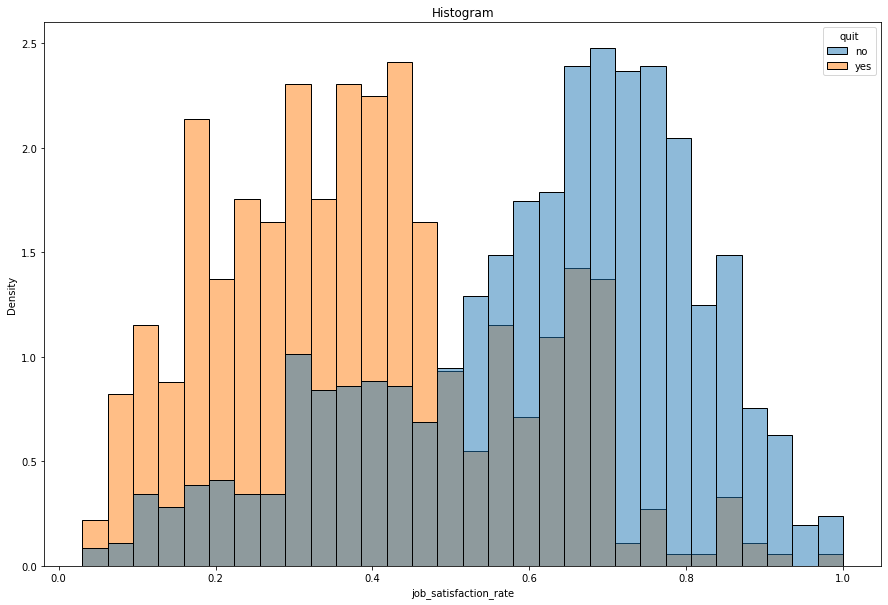

In [105]:
sns.histplot(data=target_join, x='job_satisfaction_rate', hue='quit', bins=30, stat='density', common_norm=False);
plt.title("Histogram");

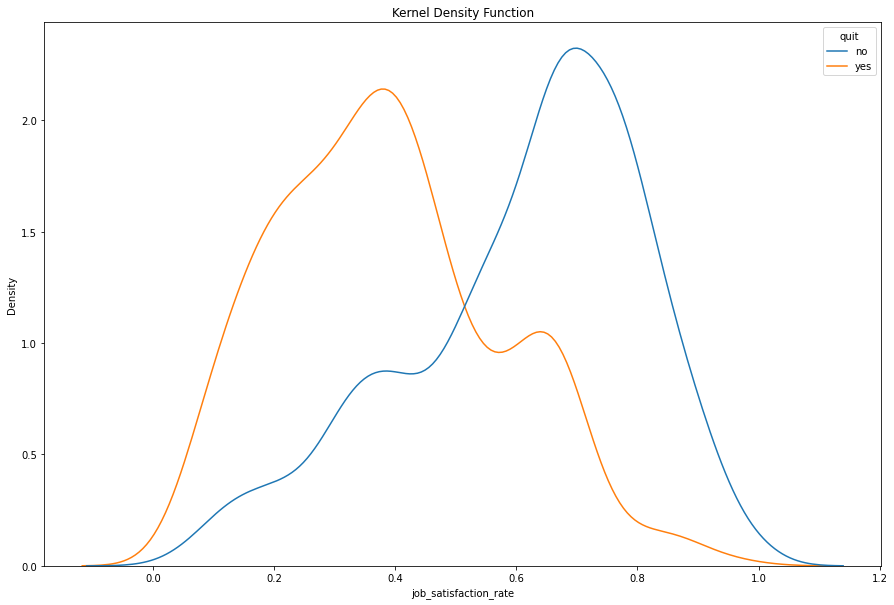

In [106]:
sns.kdeplot(x='job_satisfaction_rate', data=target_join, hue='quit', common_norm=False);
plt.title("Kernel Density Function");

Как мы видим,уволившиеся сотрудники менее удовлетворены,чем те кто остался,у уволившихся пик на 0.4,у оставшихся на 0.7.Пересечение идет на отметке в 0.5,причем у уволившихся это уже спад,а у оставшихся еще рост,аналитики были правы

**Вывод:** Провел исследовательский анализ данных.

Больше всего уволились сотрудники позиции junior, с низкой зарплатой, с низкой загруженностью, с нарушениями трудового договора, тот кто проработал менее 4 лет,с низкой зарплатой, с отдела *технологий* и низкой оценкой руководителя.

Как мы видим,уволившиеся сотрудники менее удовлетворены,чем те кто остался,у уволившихся пик на 0.4,у оставшихся на 0.7.Пересечение идет на отметке в 0.5,причем у уволившихся это уже спад,а у оставшихся еще рост,аналитики были правы.

## Шаг. Добавление нового входного признака

In [107]:
train_quit['job_satisfaction_rate'] = model.predict(train_quit)

In [108]:
features_test_quit['job_satisfaction_rate'] = model.predict(features_test_quit)
features_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 156.4+ KB


Добавил job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

## Шаг. Подготовка данных

In [109]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
lab_columns = ['quit']

In [110]:
test_quit = target_test_quit.merge(features_test_quit, on='id', how='left')

In [111]:
train = train_quit.drop(['id'], axis=1)

train.drop_duplicates(inplace=True)
train.duplicated().sum()

0

In [112]:
features_test = test_quit.drop(['quit','id'], axis=1)
target_test = test_quit['quit'] 

In [113]:
RANDOM_STATE = 42

X_train = train.drop('quit', axis=1)
y_train = train['quit'] 
X_test = features_test
y_test = target_test

In [114]:
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)

(2587, 9)
(2000, 9)
(2587,)
(2000,)


In [115]:
LabelEncoder = LabelEncoder()
y_train = LabelEncoder.fit_transform(y_train)

y_test = LabelEncoder.transform(y_test)

In [116]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'], 
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Вывод:** Поделил признаки на 2 способа кодировки и численные масштабировал:
- кодировал целевой признак через LabelEncoder
- dept, last_year_promo, last_year_violations — кодирую с помощью OneHotEncoder.
- level, workload — кодирую с помощью OrdinalEncoder, так как они имеют уровни.
- employment_years, supervisor_evaluation, salary, job_satisfaction_rate - масштабировировал.

Пропуски обработую в пайплайне.

Убрав столбец *id*, появились дубликаты в таблицах, их удалить.

## Шаг. Обучение модели

In [117]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
 
param_grid = [

    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features':  range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(
            kernel='linear',
            random_state=RANDOM_STATE,
            probability= True,
        )],
        'models__C': range(1, 5),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) ;

In [118]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(f'Метрика ROC-AUC лучшей модели на кросс-валидации: {round(randomized_search.best_score_,2)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [119]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(randomized_search.cv_results_)[
    ['std_test_score', 'rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')

,std_test_score,rank_test_score,param_models,mean_test_score,params
5,0.016432,1,DecisionTreeClassifier(random_state=42),0.889834,"{'preprocessor__num': StandardScaler(), 'models__max_features': 16, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
6,0.013806,2,DecisionTreeClassifier(random_state=42),0.874439,"{'preprocessor__num': StandardScaler(), 'models__max_features': 11, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
8,0.011790,3,DecisionTreeClassifier(random_state=42),0.868795,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
3,0.004466,4,DecisionTreeClassifier(random_state=42),0.863138,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
4,0.025908,5,DecisionTreeClassifier(random_state=42),0.844298,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 9, 'models': DecisionTreeClassifier(random_state=42)}"
1,0.022164,6,KNeighborsClassifier(),0.824120,"{'preprocessor__num': StandardScaler(), 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}"
7,0.041616,7,DecisionTreeClassifier(random_state=42),0.775245,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 6, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42)}"
9,0.036049,8,DecisionTreeClassifier(random_state=42),0.773845,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 10, 'models__max_depth': 14, 'models': DecisionTreeClassifier(random_state=42)}"
2,0.051293,9,DecisionTreeClassifier(random_state=42),0.767492,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}"
0,0.049297,10,DecisionTreeClassifier(random_state=42),0.764838,"{'preprocessor__num': 'passthrough', 'models__max_features': 2, 'models__max_depth': 16, 'models': DecisionTreeClassifier(random_state=42)}"


In [120]:
model = randomized_search.best_estimator_
y_probas = model.predict_proba(X_test)[:, 1]

In [121]:
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_probas),2)}')

Метрика ROC-AUC на тестовой выборке: 0.91


Обучил четыре модели в пайплане:
- DecisionTreeClassifier()с гиперпараметрами max_depth от 1 до 19 включительно и max_features от 1 до 19 включительно
- KNeighborsClassifier() с n_neighbors от 2 до 4
- SVC(kernel='linear', probability= True) с регуляризацией от 1 до 4
- logisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 4 включительно

Лучшей моделью оказалась DecisionTreeClassifier(max_depth=6, max_features=16), инструментом для автоматизированного поиска гиперпараметров был RandomizedSearchCV(), с маштабированием StandardScaler()

Метрика ROC-AUC модели на мтестовых данных: 0.89

Метрика ROC-AUC на тестовой выборке: 0.91

# Общий вывод

Задачи:
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
- Вторая — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

Задача №1:

Изучил данные

Предобработал данные, пропуски обработал в паплане

Удалил дубликаты после удаления столбца *id*

Кодировали данные с помощью OneHotEncoder и OrdinalEncoder,масштабировали с MinMaxScaler() и StandardScaler() в пайплане, обучил модель на тренировочной выборки, инструментом для автоматизированного поиска гиперпараметров был RandomizedSearchCV().

Обучил две модели в пайплане:
- LinearRegression()

- DecisionTreeRegressor() с гиперпараметрами от 1 до 14 включительно и max_features от 1 до 14 включительно

Лучшей моделью оказалось дерево решений, с гиперпараметрами max_depth=14, max_features=13 и маштабированием StandardScaler()

Метрика SMAPE на тренировочных показала результат 16, Метрика SMAPE на тестовых данных показала результат 14.48

Задача №2:

Изучил данные

Предобработал данные, пропуски обработал в паплане

Удалил дубликаты после удаления столбца *id*

Кодировали данные с помощью LabelEncoder, OneHotEncoder и OrdinalEncoder,масштабировали с MinMaxScaler() и StandardScaler() в пайплане, обучил модель на тренировочной выборки, инструментом для автоматизированного поиска гиперпараметров был RandomizedSearchCV().

Обучил четыре модели в пайплане:
- DecisionTreeClassifier()с гиперпараметрами max_depth от 1 до 19 включительно и max_features от 1 до 19 включительно
- KNeighborsClassifier() с n_neighbors от 2 до 4
- SVC(kernel='linear', probability= True) с регуляризацией от 1 до 4
- logisticRegression(solver='liblinear', penalty='l1') с гиперпараметром регуляризации С от 1 до 4 включительно

Лучшей моделью оказалась DecisionTreeClassifier(max_depth=6, max_features=16)

Метрика ROC-AUC модели на мтестовых данных: 0.89

Метрика ROC-AUC на тестовой выборке: 0.91

Лучшая первая модель предскажет удовлетворенность сотрудников, и компания сможет заблаговременно принять меры для увеличения этого показателя, например:
- менее строго начальством оценивать работу сотрудников
- или увеличению уровня зарплаты,потомучто разница в зарплате между уволившихся и нет,значительная
- лишь 3% сотрудников повысили,этот показатель можно увеличить, 

что в дальнейшем не приведет к уменьшению уровня мотивации и увольнению(удовлетворенность и увольнение зависимы).